In [1]:
import numpy as np, matplotlib as mpl
from Convenience import *

from Convenience import AddLikelihoods as AddProbabilities

from matplotlib.colors import LogNorm                                                                                                                                                                       
from pylab import cm 
from time import time
from matplotlib.font_manager import FontProperties
from multiprocessing import Pool

from yt.utilities.cosmology import Cosmology

%matplotlib inline

from tqdm import trange

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

colors_std = plt.rcParams['axes.prop_cycle'].by_key()['color']  ## standard color cycle



In [2]:
## these are the sets of models commonly used in Hackstein et al. 2019

models_median = {
    'model_IGM' : ['astrophysical_mean','astrophysical_median'],
    'model_Host' : ['Heesen11/dirty'],
    'weight_Host' : '',
    'model_Progenitor' : ['Piro18/wind'],
#    'model_MW' : ['JF12'],
}
models_median_noIGM = dict(models_median)
models_median_noIGM.pop('model_IGM')



models = {
    'model_IGM' : ['primordial','astrophysical'],
    'model_Host' : ['Heesen11/dirty', 'JF12/StarDensity_MW'],
    'weight_Host' : '',
    'model_Progenitor' : ['Piro18/wind', 'Piro18/uniform/Heesen11'],
    'model_MW' : ['JF12'],
}
models_all = {
    'model_IGM' : ['primordial','astrophysical'],
    'model_Progenitor' : ['Piro18/uniform/JF12','Piro18/uniform/Heesen11','Piro18/wind','Piro18/wind+SNR'],
    'model_Host' : ['JF12/Uniform', 'JF12/StarDensity_MW', 'Heesen11/dirty'], 
    'weight_Host' : '',
    
}

labels = {
    'primordial' : 'primordial',
    'astrophysical' : 'astrophysical',
    'JF12/Uniform' : 'Uniform',
    'JF12/StarDensity_MW': 'star density',
    'Heesen11/dirty': 'dwarf',
    'Piro18/uniform/JF12': 'uniform/MW',
    'Piro18/uniform/Heesen11': 'uniform/dwarf',
    'Piro18/wind': 'wind',
    'Piro18/wind+SNR': 'wind+SNR',
    'JF12': 'ne2001 + JF12'
}


models_noIGM = dict(models)
models_noIGM.pop('model_IGM')


models_full_noIGM = {
    'model_Host' : ['Heesen11/dirty'],
    'weight_Host' : '',
    'model_Progenitor' : ['Piro18/wind'],
    'model_MW' : [],
}

models_noIGM_sets = [
    dict(models_full_noIGM),
    { 
        'model_Host' : ['Heesen11/dirty'],
        'weight_Host' : '',
        'model_Progenitor' : ['Piro18/wind+SNR'],
        'model_MW' : [],
    },
    { 
        'model_Host' : ['Heesen11/dirty'],
        'weight_Host' : '',
        'model_Progenitor' : ['Piro18/uniform/Heesen11'],
        'model_MW' : [],
    },
    { 
        'model_Host' : ['JF12/StarDensity_MW'],
        'weight_Host' : '',
        'model_Progenitor' : ['Piro18/wind'],
        'model_MW' : [],
    },
    { 
        'model_Host' : ['JF12/StarDensity_MW'],
        'weight_Host' : '',
        'model_Progenitor' : ['Piro18/wind+SNR'],
        'model_MW' : [],
    },
    { 
        'model_Host' : ['JF12/StarDensity_MW'],
        'weight_Host' : '',
        'model_Progenitor' : ['Piro18/uniform/JF12'],
        'model_MW' : [],
    },
    { 
        'model_Host' : ['JF12/StarDensity_MW','Heesen11/dirty'],
        'weight_Host' : '',
        'model_Progenitor' : ['Piro18/wind'],
        'model_MW' : [],
    },
]






In [3]:
def LabelAddModel( label, model ):
    multi = len(model) > 1
    no = len(model) == 0
    
    label += r"(" * multi
    
    for m in model:
        label += labels[m]
        label += r"+" * multi
    if multi:
        label = label[:-1]
        label += r")"
    label += r"$\ast$" * ( not no )    
    return label


def LabelCombinedModel( model_Host=[], model_IGM=[], model_Progenitor=[], model_MW=[], weight_Host='' ):
    label = ''
    label = LabelAddModel( label, model_IGM )
    label = LabelAddModel( label, [ m for m in model_Host ] )
    label = LabelAddModel( label, model_Progenitor )
    label = LabelAddModel( label, model_MW )
    return label[:-6]
    '''
    for contributor in models:
        for m in contributor:
            label += contributor[m]
        label += r"$\ast$"
    else:
        label = label[:-1]
    '''

In [4]:
def AddProbability( f, x_f, g, x_g ):  ## works
    ## find unique ranges
    x = np.unique( np.append( x_f, x_g ) )
    P = np.zeros( len(x)-1 )
    ## for each bin in the first function
    for i in range( len(f) ):
    ##   find corresponding bins in solution
        in_ = (x[:-1] >= x_f[i])*(x[:-1] < x_f[i+1])
        P[in_] += f[i]
    ## same for other function
    for i in range( len(g) ):
        in_ = (x[:-1] >= x_g[i])*(x[:-1] < x_g[i+1])
        P[in_] += g[i]
    return P/2, x



def FillProbability( P, x, f, x_f ):  ## works
    ## for each bin in the function
    for i in range( len(f) ):
    ##   find corresponding bins in solution
        in_ = (x[:-1] >= x_f[i])*(x[:-1] < x_f[i+1])
    ##   and add probability
        P[in_] += f[i]
    return P
        
def AddProbabilities_( fs, xs, shrink=True, log=True ):  ## works
    if len(fs) == 1:
        return fs[0], xs[0] 
    ## find unique ranges
    x = xs[:]
    for x_ in xs[1:]:
        x = np.append( x, x_ )
    x = np.unique( x )
    P = np.zeros( len(x)-1 )
    for f, x_f in zip( fs, xs ):
        P = FillProbability( P, x, f, x_f  )
    P /= len(fs)
    if shrink:
        return ShrinkHistogram( P, x, log=log, bins=len(fs[0]) )
    else:
        return P, x
''' Is now in Convenience
def AddProbabilities( fs, xs, log=True, shrink=False ):
    if len(fs) == 1 and not shrink:
        return fs[0], xs[0] 
    ## new function support
    l = len(fs[0])
    if shrink:
        l = shrink
    if log:
        x = 10.**np.linspace( np.log10(np.min(xs)), np.log10(np.max(xs)), l+1 )
    else:
        x = np.linspace( np.min(xs), np.max(xs), l+1 )
    P = np.zeros( l )
#    P = np.zeros( len(fs[0]) )
    ## for each function
    for f, x_f in zip(fs, xs):
    ##   loop through target bins
        for ib, (b0, b1) in enumerate( zip( x, x[1:] ) ):
            ## stop when bins become too high
            if b0 > x_f[-1]:
                break
    ##     identify contributing bins
            ix, = np.where( ( x_f[:-1] < b1 ) * ( x_f[1:] > b0 ) )
            if len(ix) == 0:
                continue   ## skip if none
            elif len(ix) == 1:
                P[ib] += f[ix]  ## add if one
            else:  ## compute average of contributing bins
    ##     get corresponding ranges
                x_ = x_f[np.append(ix,ix[-1]+1)]
    ##     restrict range to within target bin
                x_[0], x_[-1] = b0, b1
    ##     add average to target probability
                P[ib] += np.sum( f[ix]*np.diff(x_) ) / (b1-b0)
    ## renormalize to 1
    P /= len(fs)
#    print 'check 1=%f' % np.sum( P * np.diff(x) )
    return P, x
'''

def ShrinkHistogram( h, x, bins=40, log=True ):  ## works
    return AddProbabilities( [h], [x], shrink=bins, log=log )
    '''
    if log:
        y = 10.**np.linspace( np.log10(x[0]), np.log10(x[-1]), bins+1 )
    else:
        y = np.linspace( x[0], x[-1], bins+1 )
    P = np.zeros( bins )
    dx = np.diff(x)
    for i , (y0,y1) in enumerate( zip( y[:-1], y[1:] ) ):
        in_, = np.where( (y0<=x[:-1])*(x[:-1]<=y1) )
        P[i] = np.sum( h[in_]*dx[in_] ) / np.sum( dx[in_] )
    P /= np.sum( P*np.diff(y) )
    return P, y
    '''

        
def ConvolveProbability( f, x_f, g, x_g, shrink=True, log=True, absolute=False ):
    
#    absolute = False ### !!!
    
    if absolute:
    ##   allow values to cancel out, assume same probability for + and -
        x_min = x_g[0] + x_f[0]  ## keep minimum of resulting x for later
        x_f = np.append( -x_f[:0:-1], np.append( 0, x_f[1:] ) )
        f = np.append( f[::-1], f )
        x_g = np.append( -x_g[:0:-1], np.append( 0, x_g[1:] ) )
        g = np.append( g[::-1], g )
    ## matrix of multiplied probabilities
    M_p = np.dot( f.reshape(len(f),1), g.reshape(1,len(g)) )
    ## matrix of combined ranges
    M_x = np.add( x_f.reshape(len(x_f),1), x_g.reshape(1,len(x_g)) )
    
    '''
    ## new function and ranges
    P = np.zeros( len(f) ) 
    x = np.linspace( x_f[0]+x_g[0], x_f[-1]+x_g[-1], len(x_f) )
    
    ## for each range
    for i, (b0, b1) in enumerate( zip( x, x[1:] ) ):
    ##   find weight of multiplied probabilities, i. e. filling factor of target bin 
        dx0 = ( M_x[1:,1:] - b0 ) / (b1 - b0)
        dx1 = ( b1 - M_x[1:,1:] ) / (b1 - b0)
    ##   use only those that contribute to target bin
        ix0 = np.where( ( 0 < dx0 )*( dx0 < 1 ) )
        ix1 = np.where( ( 0 < dx1 )*( dx1 <= 1 ) )  ## only one includes =, to not double count full spans
        P[i] += np.sum( M_p[ix0]*dx0[ix0] )
        P[i] += np.sum( M_p[ix1]*dx1[ix1] )


#    print 'check conv 1=%f' % np.sum( P * np.diff(x) )   ## !!! check not met ...
    P /= np.sum( P * np.diff(x) )
    return P, x
#    '''
    ## ranges of convolution
    x = np.unique(M_x)
    ## convolution probability
    P = np.zeros( len(x)-1 )
    ##   convolve by looping through M_p
    for i in range( len(f) ):
        for j in range( len(g) ):
    ##   for each entry, find the corresponding range in M_x
            in_ = np.where( x == M_x[i][j] )[0][0]
            out = np.where( x == M_x[i+1][j+1] )[0][0]
    ##   and add probability to convolved probability in that range
            P[in_:out] += M_p[i][j]
    if absolute:
    ##   add negative probability to positive
        x = np.append( x_min, x[1+len(x)/2:] )
        P = np.sum( [ P[:len(P)/2][::-1], P[len(P)/2:] ], axis=0 )
    ## renormalize full integral to 1
    P /= np.sum( P*np.diff(x) )
    if shrink:
        return ShrinkHistogram( P, x, bins=len(f), log=log )
    else:
        return P, x
#    '''

def ConvolveProbability_( f, x_f, g, x_g, shrink=True, log=True ):
    if log:
        x_c = 10.**np.linspace( np.log10(x_f[0]+x_g[0]), np.log10(x_f[-1]+x_g[-1]), len(x_f)  )
    else:
        x_c = np.linspace( x_f[0]+x_g[0], x_f[-1]+x_g[-1], len(x_f)  )
    P_c = np.real( np.fft.ifft( np.fft.fft( f ) * np.fft.fft( g ) ) )
    P_c /= np.sum( P_c*np.diff(x_c) )
    return P_c, x_c
    
def ConvolveProbabilities( Ps, xs, **kwargs ): #shrink=True, log=True, absolute=False ):  ## works
    P, x = Ps[0], xs[0]
    i = 0.
    for P_, x_ in zip( Ps[1:], xs[1:] ):
        P, x = ConvolveProbability( P, x, P_, x_, **kwargs ) # shrink=shrink, log=log, absolute= )
        i += 1
        P /= np.sum( P*np.diff(x) )
    return P, x


In [5]:
linestyles = {
    'IGM' : '-',
    'MilkyWay' : ':',
    'Progenitor' : '-.',
    'Host' : '--'
    
}

def ModelProbability( contributor, models, ax=None, weights=None, **kwargs ):
    Ps, xs = [], []
    for model in models:
        P, x = GetLikelihood( contributor, model, **kwargs  )
#        P, x = GetProbability( contributor, model, **kwargs  )
        
        if not ax is None:
            PlotProbability( x, P, label=labels[model], density=True, linestyle=linestyles[contributor], linewidth=0.5, ax=ax)  ### !!!
        
        Ps.append( P )
        xs.append( x )
    return AddProbabilities( Ps, xs, weights=weights )

    
    
def FullProbability( measure='DM', z=0.1, model_MW=[], model_IGM=[], model_Host=[], weight_Host='', model_Progenitor=[], nside_IGM=64, density=True, force=False, ax=None ):
    ## check if key is in probability file and return that
    if not force:
        try:
            P, x = GetLikelihood_Full( measure=measure, z=np.round(z,4), model_MW=model_MW, model_IGM=model_IGM, model_Host=model_Host, weight_Host=weight_Host, model_Progenitor=model_Progenitor )
#            P, x = GetProbability_Full( typ=typ, z=np.round(z,4), model_MW=model_MW, model_IGM=model_IGM, model_Host=model_Host, weight_Host=weight_Host, model_Progenitor=model_Progenitor )
#            P, x = GetProbability_Full( typ=typ, z=z, model_MW=model_MW, model_IGM=model_IGM, model_Host=model_Host, weight_Host=weight_Host, model_Progenitor=model_Progenitor )
            return P, x
        except:
            pass
                                  
    Ps, xs = [], []
    if len(model_MW) > 0:
        P, x = ModelProbability( 'MilkyWay', model_MW, measure=measure, ax=ax  )
        Ps.append( P )
        xs.append( x )
    if len(model_IGM) > 0:
        P, x = ModelProbability( 'IGM', model_IGM, measure=measure, z=z, distance='far' if z >= 0.1 else 'near', nside=nside_IGM, absolute=True if measure == 'RM' else False, ax=ax  )
        Ps.append( P )
        xs.append( x )
    if len(model_Host) > 0:
        P, x = ModelProbability( 'Host', model_Host, measure=measure, z=z, weight=weight_Host, ax=ax  )
        Ps.append( P )
        xs.append( x )
    if len(model_Progenitor) > 0:
        P, x = ModelProbability( 'Progenitor', model_Progenitor, measure=measure, z=z, ax=ax  )
        Ps.append( P )
        xs.append( x )
    P, x = ConvolveProbabilities( Ps, xs, absolute= measure == 'RM', shrink=True )
#    print 'check', np.sum( P*np.diff(x))
#    if not density:
#        P *= np.diff(x)
    
    ## write to file
#    key = KeyFull( typ=typ, z=z, model_MW=model_MW, model_IGM=model_IGM, model_Host=model_Host, weight_Host=weight_Host, model_Progenitor=model_Progenitor )
    key = KeyFull( measure=measure, z=np.round(z,4), model_MW=model_MW, model_IGM=model_IGM, model_Host=model_Host, weight_Host=weight_Host, model_Progenitor=model_Progenitor )
    Write2h5( likelihood_file_Full, [P,x], [ key+'/'+v for v in ['P','x']] )
    
    return P,x

In [6]:
def Histogram2Expectation( P, x, log=True,  density=True ):  ## mean works, std is slightly too high
    ## density: indicates whether P is probability density
    if log:
        x_log = np.log10(x)
        x_ = x_log[:-1] + np.diff(x_log)/2
    else:
        x_ = x[:-1] + np.diff(x)/2
    if density:
        P_ = P*np.diff(x)
    else:
        P_ = P
    if np.round( np.sum( P_ ), 2) != 1:
        sys.exit( 'P is not normalized' )
    
    x_mean = np.sum( x_*P_ )
    x_std = np.sqrt( np.sum( P_ * ( x_ - x_mean)**2 ) )
#    x_mean = np.sum( x_*P_ ) / np.sum(P_)
#    x_std = np.sqrt( np.sum( P*( x_ - x_mean)**2 ) / np.sum(P_) )
    if log:
        x_mean = 10.**x_mean
    return x_mean, x_std

def errorbar( x, y, yerr, log=True, line=False, **kwargs):  ## works
    ## if log, y_err should be given as logarithmic deviation
    if log:
        yerr_ = [ -i*(np.array(y) - 10.**( np.log10(y) + i*np.array(yerr) ) ) for i in [-1,1] ]
    else:
        yerr_ = yerr

    if not line:
        kwargs['linestyle'] = ''
    
    plt.errorbar( x, y, yerr=yerr_, **kwargs )

In [7]:
def ObservableProbability( min=1., **kwargs ):
    P, x = FullProbability( **kwargs )
    ix, = np.where( x >= min )
    x = x[ix]
    P = P[ix[:-1]]
    P /= np.sum( P*np.diff(x) )
    return P, x

In [8]:

def PlotContributions( typ='DM', model_MW=['JF12'], model_IGM=['primordial'], model_Host=['JF12'], weight_Host='StarDensity_MW', model_Progenitor=['Piro18/uniform'], nside_IGM=64, distance='far', errorspan=1, plot_full=False, check_probabilities=False, colors=colors_std, legend=False ):
    if distance == 'far':
        zs = np.linspace( 0.1, 6.0, 60)
    elif distance == 'near':
        zs = np.array( h5.File( likelihood_file_IGM )['primordial/near/64/DM'].keys() ).astype('f')

    icolor=0
        
    ## for each contributor (linestyle)
    ##   draw graph of mean+std(z) for each model
    plt.loglog()
    mean_full, std_full = np.zeros( [2,len(zs)] )
    
    ## IGM
    plt.plot( [0],[0],label=r"$\rm \bf IGM$:", linestyle='')
    for model in model_IGM:
        mean, std = [], []
        for z in zs:
            P, x = GetProbability( 'IGM', model, density=True, typ=typ, z=z, distance=distance, nside=nside_IGM, absolute=True if typ == 'RM' else False  )
            if check_probabilities:
                print 'IGM', model, "%.2f" % np.round( np.sum(P*np.diff(x)), 2)
            x_mean, x_std = Histogram2Expectation( P, x )
            mean.append( x_mean )
            std.append( x_std )
#        plt.plot( 1+zs, mean, linestyle='-', label='IGM '+model, color=colors[icolor], linewidth=3 )
        plt.plot( zs, mean, linestyle='-', label=labels[model], color=colors[icolor], linewidth=3 )
        errorbar( zs[errorspan*1:], mean[errorspan*1:], std[errorspan*1:], errorevery=5*errorspan if errorspan else 1, linestyle='-', color=colors[icolor], log=True, capsize=5 )
        icolor += 1
    if len( model_IGM )>0:
        mean_full += np.array(mean)
        std_full += np.array(std)
        
    ## this is only for aesthetics !!!
    ii = len(model_IGM)
    while ii < 2:
        ii += 1
        icolor += 1

    ## Host
    plt.plot( [0],[0],label=r"$\rm \bf Host$:", linestyle='')
    for model in model_Host:
        mean, std = [], []
        for z in zs:
            P, x = GetProbability( 'Host', model, typ=typ, z=z, weight=weight_Host )
            if check_probabilities:
                print 'Host', model, "%.2f" % np.round( np.sum(P*np.diff(x)), 2)
            x_mean, x_std = Histogram2Expectation( P, x )
            mean.append( x_mean )
            std.append( x_std )
        plt.plot( zs, mean, linestyle='--', label=labels[model], color=colors[icolor], linewidth=3 )
        errorbar( zs[errorspan*2:], mean[errorspan*2:], std[errorspan*2:], errorevery=5*errorspan if errorspan else 1, linestyle='--', color=colors[icolor], log=True, capsize=5 )
        icolor += 1
    if len( model_Host )>0:
        mean_full += np.array(mean)
        std_full += np.array(std)

    ## this is only for aesthetics !!!
    ii = len(model_IGM) + len(model_Host)
    while ii < len(model_Progenitor) + len(model_MW):
        plt.plot( [0],[0],label=r" ", linestyle='')
        
        
    ## Progenitor
    plt.plot( [0],[0],label=r"$\rm \bf Progenitor$:", linestyle='')
    for model in model_Progenitor:
        mean, std = [], []
        for z in zs:
            P, x = GetProbability( 'Progenitor', model, typ=typ, z=z  )
            if check_probabilities:
                print 'progenitor', model, "%.2f" % np.round( np.sum(P*np.diff(x)), 2)
            x_mean, x_std = Histogram2Expectation( P, x )
            mean.append( x_mean )
            std.append( x_std )
        plt.plot( zs, mean, linestyle='-.', label=labels[model], color=colors[icolor], linewidth=3 )
        errorbar( zs[errorspan*3:], mean[errorspan*3:], std[errorspan*3:], errorevery=5*errorspan if errorspan else 1, linestyle='-.', color=colors[icolor], log=True, capsize=5 )
        icolor += 1
    if len( model_Progenitor )>0:
        mean_full += np.array(mean)
        std_full += np.array(std)

    ## Milky Way
    plt.plot( [0],[0],label=r"$\rm \bf Milky Way$:", linestyle='')
    for model in model_MW:
        P, x = GetProbability( 'MilkyWay', model, typ=typ  )
        if check_probabilities:
            print 'MW', model, "%.2f" % np.round( np.sum(P*np.diff(x)), 2)
        x_mean, x_std = Histogram2Expectation( P, x )
        plt.plot( zs, [x_mean]*len(zs), linestyle=':', label=labels[model], color=colors[icolor], linewidth=3 )
        errorbar( zs, [x_mean]*len(zs), [x_std]*len(zs), errorevery=errorspan*5 if errorspan else 1, linestyle=':', color=colors[icolor], log=True, capsize=5 )
        icolor += 1
    if len( model_MW )>0:
        mean_full += x_mean
        std_full += x_std

    ## this is only for aesthetics !!!
    ii = len(model_Progenitor) + len(model_MW)
    while ii < len(model_IGM) + len(model_Host):
        plt.plot( [0],[0],label=r" ", linestyle='')
        ii += 1
        
    plt.xlabel( 'redshift')
    plt.ylabel( r"$\langle$%s$\rangle \pm 1\sigma$ [%s]" % ( typ, units[typ] ) )
    if legend:
        plt.legend(prop={'size':12}, handlelength=5, ncol=2, 
                   bbox_to_anchor= (0., 1.01, 1, 0.1), loc='lower left',
                   borderaxespad=0, frameon=False, markerfirst=False, mode='expand'
          )
    if plot_full:
        plt.plot( zs, mean_full, linestyle='-', label='total', color='black', linewidth=3 )
        errorbar( zs, mean_full, std_full, errorevery=errorspan if errorspan else 1, linestyle='-', color='black', log=True )
        mean, std = [], []
        '''
        for z in zs:
            P, x = FullProbability( typ=typ, z=z, model_MW=model_MW, model_IGM=model_IGM, model_Host=model_Host, model_Progenitor=model_Progenitor, weight_Host=weight_Host )
            x_mean, x_std = Histogram2Expectation( P, x )
            mean.append( x_mean )
            std.append( x_std )
        plt.plot( 1+zs, mean, linestyle=':', label='total_P', color='red', linewidth=10 )
        errorbar( 1+zs, mean, std, errorevery=errorspan if errorspan else 1, linestyle=':', color='red', log=True )
        ''' 
    return mean_full, std_full
    

In [9]:
def Probabilities( measurements, P, x ):
    i = 0  ## marker for current bin
    Ps = np.zeros( len( measurements ) ) ## collector for probabilities of measurements
    dx = np.diff(x)
    isort = np.argsort( measurements )   ## sorted order of measurements
    ## for each measurement (in ascending order)
    #for m, i_s in zip( np.sort(measurements), isort ):
    for m, i_s in zip( np.array(measurements)[isort], isort ):
    ##   check all bins >= previous results
        for xi in x[i:]:
    ##      whether measure is inside
            if m >= xi:  ## measure is bigger than current bin range
                i += 1  ##   set marker to next bin range
                continue
            else:       ## otherwise, measure is in the bin
                        ## put result in correct place
                ## use probbility 
#                Ps[i_s] = P[i-1]*dx[i-1]  if i > 0 else 1e-9  ## if that was the lowest bound, probability is ->zero if measurement is outside the range of P, i. e. P~0
                ## use probbility density  # this is correct to be used, as this doesn't depend on binning. with same binning, identical factor is multiplied to density
                Ps[i_s] = P[i-1]  if i > 0 else 1e-9  ## if that was the lowest bound, probability is ->zero if measurement is outside the range of P, i. e. P~0
                break   ##   stop checking bins
        else:
            ## if measure is bigger than the last bin
            Ps[i_s] = 0  ## probability is zero if measurement is outside the range of P, i. e. P~0
    
    return np.array( Ps )

def Probabilities_( measurements, P, x ):
    ## find for each measurement
    m = np.reshape( measurements, [ len(measurements), 1 ] )
    ## the corresponding bin in P
    b = ( m > x[:-1] ) * ( m < x[1:] )
    ## check for all measurements
    for bl in b:
    ##   where measurement is outside range of P
        if not np.any( bl ):
    ##     use value at the lowest border, usually the lowest
            bl[0]=True
    ix = np.where( b )
    res = P[ix[1]]
    ## check for 0 values (can result in NaN), replace by low number
    res[ res == 0 ] = 1e-8
    ## return corresponding probabilities
    return 



def Likelihood( measurements, P, x, prior=1. ):
    Ps = Probabilities( measurements, P, x )
    ## full probability is the product of probabilities of all measurement
    ## since all assume the same model corresponding to the probability function, the same prior is applied to all of them
    return np.product( Ps )*prior

def BayesFactor( measurements, model1, model2 ):
    ## computes Bayes factor that indicates how much measurements favor model1 over model2
#    P1, x1 = FullProbability( **model1 )
#    P2, x2 = FullProbability( **model2 )
    P1, x1 = ObservableProbability( **model1 )
    P2, x2 = ObservableProbability( **model2 )
    return Likelihood( measurements, P1, x1 ) / Likelihood( measurements, P2, x2 )
    
## include both, far and near, to be more clean. far begins, where near ends
zs_near = np.array( h5.File( likelihood_file_IGM )['primordial/near/64/DM'].keys() ).astype('f')
zs_far = np.linspace( 0.1, 6.0, 60 )   ### !!! clean up that mess !!!    use dictionary for far and near zs
zs_ = np.append( zs_near, zs_far )
## no, do not include, requires careful consideration of prior! we are only interested in far FRBs anyways
zs_ = zs_far
zs_range = zs_[:-1] - np.diff(zs_)/2
zs_range = np.append( zs_range, zs_[-2:] + np.diff(zs_[-3:])/2 )

def RedshiftProbability( DMs, model, SMs=None, population='flat', telescope='None' ):
    ## returns likelihood function of redshift for an observed DM
    ## can be used to obtain estimate and deviation
    
    Pz = np.zeros( [len(DMs),len(zs_)] )
    ## for each redshift
    for iz, z in enumerate(zs_):
        ## calculate the likelihood of observed DM 
        Pz[:,iz] = Probabilities( DMs, *FullProbability( typ='DM', z=z, density=True, **model) ) 
    
    ## improve redshift estimate with additional information from SM, which is more sensitive to high overdensities in the LoS
    if SMs is not None:
        Pz_ = np.zeros( [len(DMs),len(zs_)] )
        for iz, z in enumerate(zs_):
            Pz_[:,iz] = Probabilities( SMs, *FullProbability( typ='SM', z=z, density=True, **model) ) 
        Pz *= Pz_
    
    ## consider prior likelihood on redshift according to FRB population and telescope selection effects 
    if population == 'flat':
        pi_z = np.array([1.])
    else:
        pi_z = GetLikelihood_Redshift( population=population, telescope=telescope )
    Pz *= np.resize( pi_z, [1,len(zs_)]
                    
    ## renormalize to 1 for every DM
    Pz /= np.resize( np.sum( Pz * np.resize( np.diff( zs_range ), [1,len(zs_range)-1] ), axis=1 ), [len(DMs),1] )  
    
    return Pz, zs_range


def CombinedLikelihood( DMs, RMs, model={}, prior_BO=1., prior_z=[1.]*len(zs_), SMs=None, population='flat', telescope='None' ):
    res = np.zeros( len(DMs) )
    
    #### !!!!! careful here!!! the full probability space is not normalized to 1 !!!!
    
    P_z_DMs, zs = RedshiftProbability( DMs, model, SMs=SMs, population=population, telescope=telescope )
    
#    for z, pi_z in zip( zs_, prior_z ):
#        res += prior_BO*pi_z * Probabilities( DMs, *FullProbability( typ='DM', z=z, density=False, **model) ) * Probabilities( RMs, *FullProbability( typ='RM', z=z, density=False, **model) )
    for z, p_z, pi_z in zip( zs_, P_z_DMs.transpose(), prior_z ):
#        res += prior_BO*pi_z * p_z * Probabilities( RMs, *FullProbability( typ='RM', z=z, density=False, **model) )
        res += prior_BO*pi_z * p_z * Probabilities( RMs, *ObservableProbability( typ='RM', z=z, density=False, **model) )
    nans = np.isnan(res)
    infs = np.isinf(res)
#    if np.any( nans ):
#        res[ nans ] = 1.  # clean NaNs for now !!!
#    if np.any( infs ):
#        res[ infs ] = 1.  # clean infs for now !!!
#    return np.prod(res)
    return res

def CombinedBayesFactor( DMs, RMs, model1, model2 ):
    return np.prod( CombinedLikelihood( DMs, RMs, model1 ) / CombinedLikelihood( DMs, RMs, model2 ) )

KeyError: 'Unable to open object (component not found)'

In [10]:
def PlotContributorProbabilties( typ='DM', model_MW=['JF12'], model_IGM=['primordial'], model_Host=['JF12'], weight_Host='StarDensity_MW', model_Progenitor=['Piro18/uniform'], redshift=0.1, nside_IGM=64, distance='far', errorspan=1, plot_full=False, check_probabilities=False , ax=None, legend=True, colors=colors_std):
    if ax is None:
        fig, ax = plt.subplots( figsize=(8,3) )

    icolor = 0
    ## IGM
    ax.plot( [0],[0],label=r"$\rm \bf IGM$:", linestyle='')
    for model in model_IGM:
        P, x = GetProbability( 'IGM', model, density=True, typ=typ, z=redshift, distance=distance, nside=nside_IGM, absolute=True if typ == 'RM' else False  )
        PlotProbability( x, P, color=colors[icolor], linestyle='-', label=model, ax=ax, density=False)
        icolor += 1

    ## this is only for aesthetics !!!
    ii = len(model_IGM)
    while ii < 2:
        ii += 1
        icolor += 1

        
    ## Host
    ax.plot( [0],[0],label=r"$\rm \bf Host$:", linestyle='')
    for model in model_Host:
        P, x = GetProbability( 'Host', model, typ=typ, z=redshift, weight=weight_Host )
        PlotProbability( x, P, color=colors[icolor], linestyle='--', label=model, ax=ax, density=False)
        icolor += 1
        
    ## this is only for aesthetics !!!
    ii = len(model_IGM) + len(model_Host)
    while ii < len(model_Progenitor) + len(model_MW):
        plt.plot( [0],[0],label=r" ", linestyle='')
        
    ## Progenitor
    ax.plot( [0],[0],label=r"$\rm \bf Progenitor$:", linestyle='')
    for model in model_Progenitor:
        P, x = GetProbability( 'Progenitor', model, typ=typ, z=redshift  )
        PlotProbability( x, P, color=colors[icolor], linestyle='-.', label=model, ax=ax, density=False )#, linewidth=5 )
        icolor += 1

    ## Milky Way
    ax.plot( [0],[0],label=r"$\rm \bf Milky Way$:", linestyle='')
    for model in model_MW:
        P, x = GetProbability( 'MilkyWay', model, typ=typ  )
        PlotProbability( x, P, color=colors[icolor], linestyle=':', label=model, ax=ax, density=False)
        icolor += 1

    ## this is only for aesthetics !!!
    ii = len(model_Progenitor) + len(model_MW)
    while ii < len(model_IGM) + len(model_Host):
        plt.plot( [0],[0],label=r" ", linestyle='')
        ii += 1
        
    fontP = FontProperties()
    fontP.set_size('small')
#    ax.text( ax.get_xlim()[0]*3, 0.1, "z = %.1f" % redshift, fontdict={'size':  20})#  12} )
    ax.text( 1e-6                , 0.1, "z = %.1f" % redshift, fontdict={'size':  20})#  12} )
    ax.set_ylabel( r"P(%s)$\Delta$%s" % (typ, typ) )
    ax.set_ylim(1e-4,0.9)
    ax.set_xlabel( units[typ], fontdict={'size':16} )
    if legend:
        
        ax.legend(prop={'size':11}, handlelength=5, ncol=2, 
                   bbox_to_anchor= (0., 1.01, 1, 0.1), loc='lower left',
                   borderaxespad=0, frameon=False, markerfirst=False, mode='expand'
          )
#        ax.legend( prop=fontP )# loc='upper left')
#    ax.legend( prop=fontP )# loc='upper left')
    

In [11]:
def PlotContributorProbabilties_groups( typ='DM', model_MW=['JF12'], model_IGM=['primordial'], model_Host=['JF12'], weight_Host='StarDensity_MW', model_Progenitor=['Piro18/uniform'], redshift=0.1, nside_IGM=64, distance='far', errorspan=1, plot_full=False, check_probabilities=False , axs=None, legend=True, colors=colors_std):
    if axs is None:
        fig, axs = plt.subplots( 2, 1, figsize=(8,6), sharex='all' )
        fig.subplots_adjust( wspace=0, hspace=0)
        axs[0].set_title( typ, size=20 )
    for ax in axs:
        #ax.set_ylabel( 'Probability', size=16)
        ax.tick_params(labelsize=20)
        ax.set_ylim(1e-4,0.9)

    ax = axs[0]
    
    if typ == 'DM':
        ax.set_xlim(1e-5,1e6)
    elif typ == 'RM':
        ax.set_xlim(1e-8,1e9)
        

    icolor = 0
    ## IGM  
    ax.plot( [0],[0],label=r"$\rm \bf IGM$:", linestyle='')
    for model in model_IGM:
        P, x = GetProbability( 'IGM', model, density=True, typ=typ, z=redshift, distance=distance, nside=nside_IGM, absolute=True if typ == 'RM' else False  )
        PlotProbability( x, P, typ=typ, color=colors[icolor], linestyle='-', label=labels[model], ax=ax, density=False)
        icolor += 1

    ## this is only for aesthetics !!!
    ii = len(model_IGM)
    while ii < 2:
        ii += 1
        icolor += 1

        
    ## Host
    ax.plot( [0],[0],label=r"$\rm \bf Host$:", linestyle='')
    for model in model_Host:
        P, x = GetProbability( 'Host', model, typ=typ, z=redshift, weight=weight_Host )
        PlotProbability( x, P, color=colors[icolor], linestyle='--', label=labels[model], ax=ax, density=False)
        icolor += 1
        
    ## this is only for aesthetics !!!
    ii = len(model_IGM) + len(model_Host)
    while ii < len(model_Progenitor) + len(model_MW):
        ax.plot( [0],[0],label=r" ", linestyle='')

    ax = axs[1]
    
    ## Progenitor
    axs[0].plot( [0],[0],label=r"$\rm \bf Progenitor$:", linestyle='')
    for model in model_Progenitor:
        P, x = GetProbability( 'Progenitor', model, typ=typ, z=redshift  )
        PlotProbability( x, P, typ=typ, color=colors[icolor], linestyle='-.', label=labels[model], ax=ax, density=False )#, linewidth=5 )
        PlotProbability( x[:2], P[:1], color=colors[icolor], linestyle='-.', label=labels[model], ax=axs[0], density=False )#, linewidth=5 )
        icolor += 1

    ## Milky Way
    axs[0].plot( [0],[0],label=r"$\rm \bf Milky Way$:", linestyle='')
    for model in model_MW:
        P, x = GetProbability( 'MilkyWay', model, typ=typ  )
        PlotProbability( x, P, color=colors[icolor], linestyle=':', label=labels[model], ax=ax, density=False)
        PlotProbability( x[:2], P[:1], color=colors[icolor], linestyle=':', label=labels[model], ax=axs[0], density=False)
        icolor += 1

    ## this is only for aesthetics !!!
    ii = len(model_Progenitor) + len(model_MW)
    while ii < len(model_IGM) + len(model_Host):
        ax.plot( [0],[0],label=r" ", linestyle='')
        ii += 1
        
    fontP = FontProperties()
    fontP.set_size('small')
#    ax.text( ax.get_xlim()[0]*3, 0.1, "z = %.1f" % redshift, fontdict={'size':  20})#  12} )
    ax.text( 1e-4 if typ=='DM' else 1e-5                , 0.1, "z = %.1f" % redshift, fontdict={'size':  20})#  12} )
#    ax.set_ylabel( r"P(%s)$\Delta$%s" % (typ, typ) )

#    ax.set_xlabel( units[typ], fontdict={'size':16} )
    if legend:
#        for ax in axs:
#            ax.legend( prop={'size':12})
        
        axs[0].legend(prop={'size':12}, handlelength=5,
#                   bbox_to_anchor= (0., 1.01, 1, 0.1), loc='lower left', ncol=2,  markerfirst=False, mode='expand',
                   bbox_to_anchor= (1., -0.85, 0.3, 1.0), loc='lower left', ncol=1, 
                   borderaxespad=0, frameon=False,
          )
#        ax.legend( prop=fontP )# loc='upper left')
#    ax.legend( prop=fontP )# loc='upper left')
    

In [12]:

def RandomSample( N, P, x, log=True ):
    ## P is probability, not probability density, i. e. sum(P)=1
    if np.round( np.sum(P), 4) != 1:
        sys.exit( " 1 != %f" % (np.sum(P)) )
    f = P.max()
    lo, hi = x[0], x[-1]
    if log:
        lo, hi = np.log10( [lo,hi] )
    res = []
    while len(res) < N:
        r = np.random.uniform( high=hi, low=lo, size=N )
        if log:
            r = 10.**r
        z = np.random.uniform( size=N )
        p = Probabilities( r, P/f, x )
        res.extend( r[ np.where( z < p )[0] ] )
    return res[:N]

In [13]:
HubbleConstant = 0.71
OmegaMatter = 0.27
OmegaLambda = 0.73
OmegaCurvature = 0.0

co = Cosmology( hubble_constant=HubbleConstant, omega_matter=OmegaMatter, omega_lambda=OmegaLambda, omega_curvature=OmegaCurvature)
comoving_radial_distance = lambda z: co.comoving_radial_distance(0,z).in_units('Mpc')

In [14]:
full = True
#full = False
 
dist = 'far'
dist = 'near'

def PlotPEvolution( full=True, dist='far', models_noIGM=models_full_noIGM ):

    if dist == 'far':
        zs = np.array([0.1,1.,2.,3.,4.,5.])
        zs = np.linspace(0.1,6.0,60)[::1]
    elif dist == 'near':
        redshift_max_near = 0.042142996600424976
        N_skymaps_near = 10
        zs = np.linspace(0,redshift_max_near,1+N_skymaps_near)[1:]
        ds = np.array( [ comoving_radial_distance( z ) for z in zs ] )
    colors = cm.rainbow( np.linspace( 0, 1, len( zs ) ) )

    if dist == 'far':
        mp = plt.imshow( zs.reshape([len(zs),1]), cmap=cm.rainbow )
    elif dist == 'near':
        mp = plt.imshow( ds.reshape([len(ds),1]), cmap=cm.rainbow )
        
    plt.show()

    cb_label = 'redshift' if dist == 'far' else 'Mpc'

    fig, ax = plt.subplots()


    #'''
    for c, z in zip( colors, zs ):
        if full:
            P, x = FullProbability( z=z, typ='DM', model_IGM=['primordial'], **models_noIGM )
        else:
            P, x = GetProbability( 'IGM', 'primordial', z=z, typ='DM', absolute=False, distance=dist )            
    #    P, x = FullProbability(z=z, typ='DM', model_IGM=['primordial'] )
        PlotProbability( x, P, ax=ax, label='z = %f' % z, typ='DM', density=False, color=c )
    #plt.legend()
    
    #plt.text( 1e1, 1, 'primordial'+', '+ ('full' if full else 'IGM'), fontsize=20 )
    if full:
        plt.text( 1e0, 1, LabelCombinedModel( model_IGM=['primordial'], **models_noIGM ), fontsize=20 )
    else:
        plt.text( 1e0, 1, 'primordial', fontsize=20 )


    #plt.xlabel( ' pc cm$^{-3}$' )
    #plt.ylabel( r"P(DM)$\Delta$DM")
    plt.xlim(0.6,3e4)
    plt.ylim( 1e-4, 9e0)
    ax.tick_params(labelsize=20)

    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = plt.colorbar( mp, cax=cbar_ax )
    cb.ax.tick_params( labelsize=16 )
    cb.set_label(label=cb_label, size=16)


    plt.show()
    #'''



    fig, axs = plt.subplots( 2, 1, figsize=(6,8), sharex='all' )
    fig.subplots_adjust( hspace=0 )
    #fig, axs = plt.subplots( 1, 2, figsize=(12,4), sharey='all' )
    #fig.subplots_adjust( wspace=0 )
    #fig, ax = plt.subplots( figsize=(6,4) )
    for i, model in enumerate( ['primordial','astrophysical'] ):
        if full:
            axs[i].text( 1e-5, 0.1, LabelCombinedModel( model_IGM=[model], **models_noIGM ), fontsize=20 )
        else:
            axs[i].text( 1e-5, 0.1, model, fontsize=20 )

#        for i_z in trange( len(zs) ):
#            z = zs[i_z]
#            c = colors[i_z]
        for c, z in zip( colors, zs ):
            if full:
                P, x = FullProbability(z=z, typ='RM', model_IGM=[model], **models_noIGM)
            else:
                P, x = GetProbability( 'IGM', model, z=z, measure='RM', absolute=True, distance=dist )            
            PlotProbability( x, P, ax=axs[i], label='z = %.1f' % z, density=False, color=c, typ='RM' )
    #        PlotProbability( x, P, ax=ax, label='z = %f' % z, density=False, linestyle='-.' )
    #plt.legend(loc='right')
    for ax in axs:
        ax.tick_params(labelsize=20)
    #    ax.set_ylabel( r"P(RM)$\Delta$RM")
        ax.set_ylim(7e-5, 0.7)
        ax.set_xlim(1e-6, 1e5)
    #    ax.set_xlabel(r"rad m$^{-2}$")
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

    cb = plt.colorbar( mp, cax=cbar_ax )

    cb.ax.tick_params( labelsize=16 )
    cb.set_label(label=cb_label, size=16)
    plt.show()

In [15]:
models_median_noIGM

{'model_Host': ['Heesen11/dirty'],
 'model_Progenitor': ['Piro18/wind'],
 'weight_Host': ''}

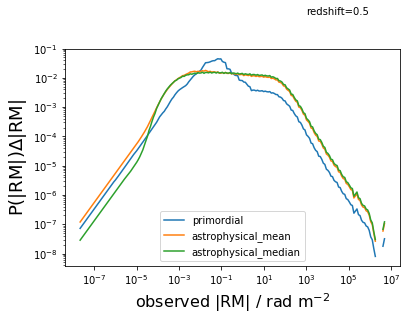

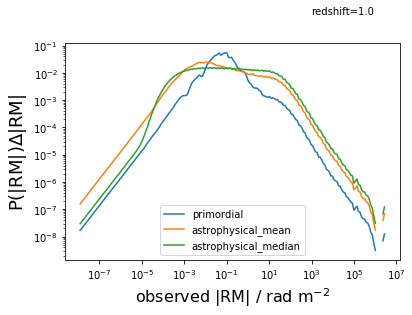

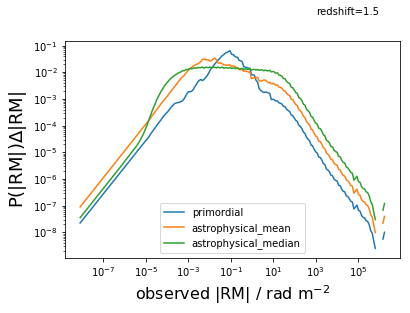

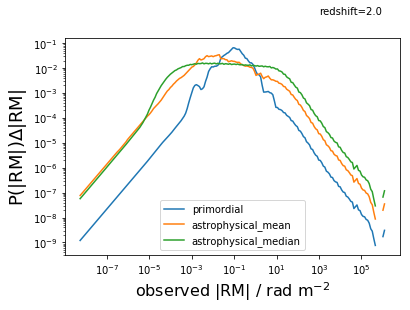

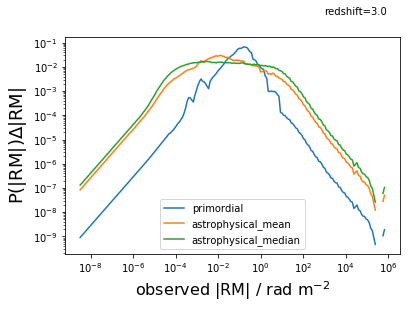

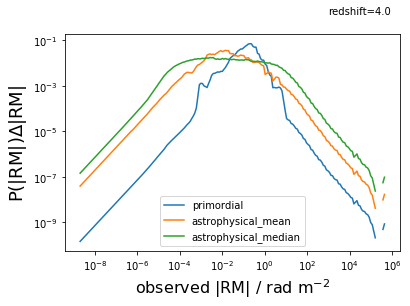

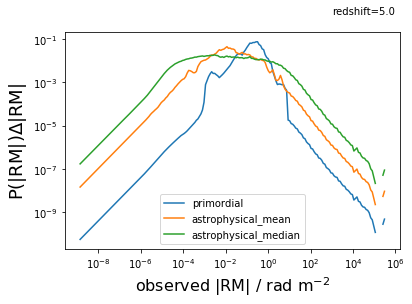

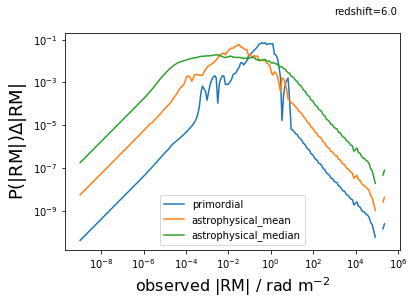

In [19]:
for z in [0.5,1,1.5,2,3,4,5,6]:
    fig, ax = plt.subplots()
    P, x = FullProbability(z=z, measure='RM', model_IGM=['primordial'], nside_IGM=4, **models_median_noIGM)
    PlotLikelihood( x, P, measure='RM', ax=ax, label='primordial' )
    P, x = FullProbability(z=z, measure='RM', model_IGM=['astrophysical_mean'], nside_IGM=4, **models_median_noIGM)
    PlotLikelihood( x, P, measure='RM', ax=ax, label='astrophysical_mean' )
    P, x = FullProbability(z=z, measure='RM', model_IGM=['astrophysical_median'], nside_IGM=4, **models_median_noIGM)
    PlotLikelihood( x, P, measure='RM', ax=ax, label='astrophysical_median')
    ax.text( 1e3, 1.4, 'redshift=%.1f' % z )
#    plt.xlim(1,1e7)
    plt.legend()
    plt.show()


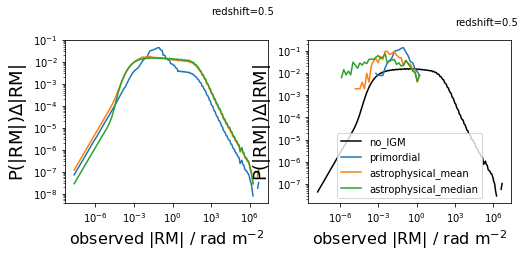

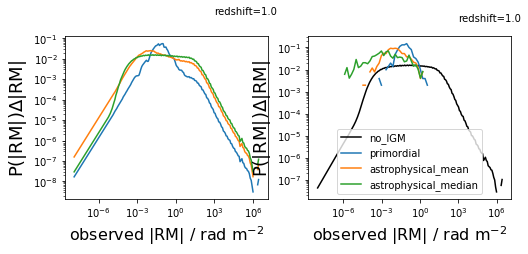

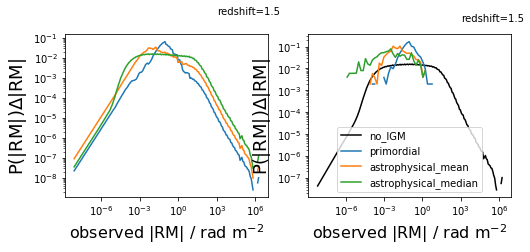

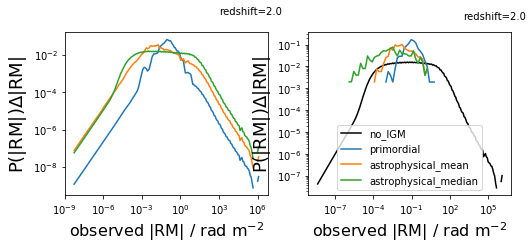

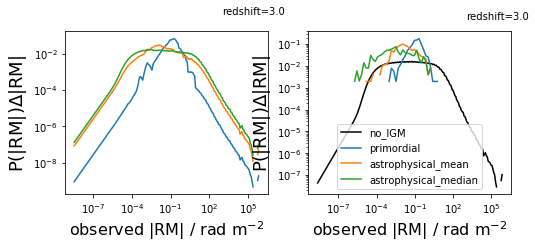

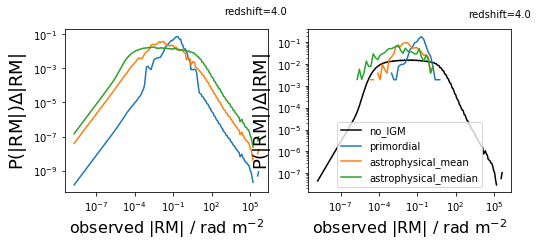

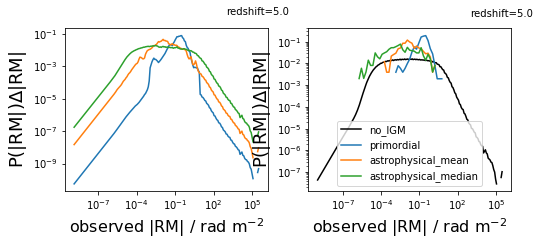

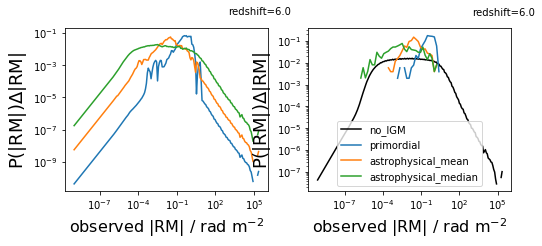

In [17]:
for z in [0.5,1,1.5,2,3,4,5,6]:
    fig, axs = plt.subplots(1,2,figsize=(8,3))
    ax = axs[0]
    P, x = FullProbability(z=z, measure='RM', model_IGM=['primordial'], nside_IGM=4, force=True, **models_median_noIGM)
    PlotLikelihood( x, P, measure='RM', ax=ax, label='primordial' )
    P, x = FullProbability(z=z, measure='RM', model_IGM=['astrophysical_mean'], nside_IGM=4, force=True, **models_median_noIGM)
    PlotLikelihood( x, P, measure='RM', ax=ax, label='astrophysical_mean' )
    P, x = FullProbability(z=z, measure='RM', model_IGM=['astrophysical_median'], nside_IGM=4, force=True, **models_median_noIGM)
    PlotLikelihood( x, P, measure='RM', ax=ax, label='astrophysical_median')
    ax.text( 1e3, 1.4, 'redshift=%.1f' % z )
#    plt.xlim(1,1e7)
    plt.legend()

    ax = axs[1]
    P, x = FullProbability(z=z, measure='RM', model_IGM=[], nside_IGM=4, force=True, **models_median_noIGM )
    PlotLikelihood( x, P, measure='RM', ax=ax, label='no_IGM', color='black' )
    P, x = FullProbability(z=z, measure='RM', model_IGM=['primordial'], nside_IGM=4, force=True )
    PlotLikelihood( x, P, measure='RM', ax=ax, label='primordial' )
    P, x = FullProbability(z=z, measure='RM', model_IGM=['astrophysical_mean'], nside_IGM=4, force=True)
    PlotLikelihood( x, P, measure='RM', ax=ax, label='astrophysical_mean' )
    P, x = FullProbability(z=z, measure='RM', model_IGM=['astrophysical_median'], nside_IGM=4, force=True)
    PlotLikelihood( x, P, measure='RM', ax=ax, label='astrophysical_median')
    
    ax.text( 1e3, 1.4, 'redshift=%.1f' % z )
#    plt.xlim(1,1e7)
    plt.legend()
    plt.show()
    

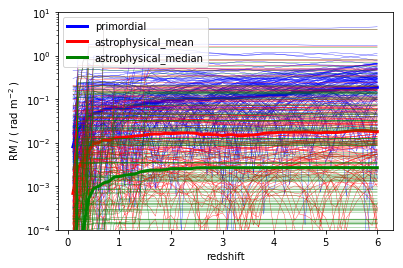

In [62]:
with h5.File( '/hummel/PreFRBLE/results/LoS_observables.h5' ) as f:
    zs = np.arange(0.1,6.1,0.1)
    for model, color in zip(['primordial', 'astrophysical_mean', 'astrophysical_median'],['blue','red','green']):
        RMs = []
        for ipix in range(128):
            RMs.append( f['%s/chopped/%i/RM' % ( model, ipix )].value )
            plt.plot( zs, np.abs(RMs[-1]), color=color, linewidth=0.3 )
        plt.plot( zs, 10.**np.mean(np.log10(np.abs(RMs)), axis=0), label=model, linewidth=3, color=color )
plt.legend()
plt.yscale('log')
plt.xlabel('redshift')
plt.ylabel(' RM / ( rad m$^{-2}$ )')
plt.ylim(1e-4,1e1)
plt.show()
plt.close()

In [10]:
DM_repeater = 557.
Ps, x = RedshiftProbability( [DM_repeater] , model={} )

print Ps

[[1.72200901e-01 1.81567204e-01 1.77791263e-01 1.69803021e-01
  1.79531852e-01 1.75469041e-01 1.80195194e-01 1.74969055e-01
  1.68534229e-01 1.77004708e-01 1.60985312e-01 2.47110895e-01
  5.56747455e-01 1.00479457e+00 2.50522985e+00 3.69632601e+00
  1.29807037e+00 4.34713562e-01 9.47467299e-03 3.40027186e-05
  1.17615114e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

557.0 0.4984674828855068 0.18769161623071395


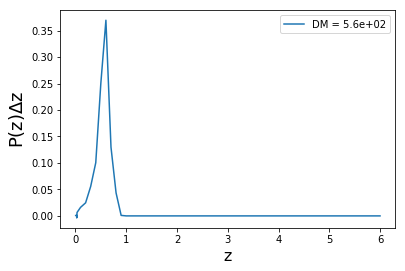

In [11]:
fig, ax = plt.subplots()
for P, DM in zip( Ps, [DM_repeater]) :
    P_ = P # / np.sum( P *np.diff(x) )
    PlotProbability( x, P_, density=False, ax=ax, log=False, label='DM = %.1e' % DM, typ='z' )
    m, s = Histogram2Expectation(P=P_, x=x, log=True)
    print DM, m, m-10.**(np.log10(m)-s)
plt.legend()


In [12]:
DMs = 10**np.linspace(2.5,3.5, 10)
Ps, x = RedshiftProbability( DMs , model={} )

316.22776601683796 0.2002788508091064 0.09141601284537182
408.4238652674522 0.30465204999112905 0.12829531942343148
527.499706370262 0.47109276472069633 0.17813377988554235
681.2920690579615 0.6894535170741236 0.2329828688099953
879.9225435691075 1.0912644170142525 0.3007819014753177
1136.4636663857243 1.7510989404303354 0.36197177691026083
1467.799267622069 3.024349635280592 0.5709050468285519
1895.7356524063753 5.178108048031246 0.7732517053401615
2448.4367468222267 3.995096454685483 2.0897949628235106
3162.2776601683795 2.758336065636679 2.116096916275237


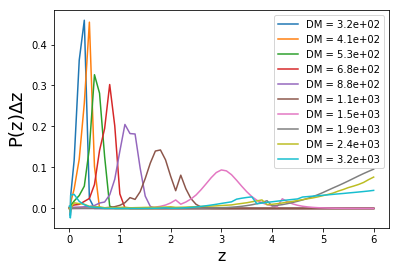

In [13]:
fig, ax = plt.subplots()
for P, DM in zip( Ps, DMs) :
    P_ = P # / np.sum( P *np.diff(x) )
    PlotProbability( x, P_, density=False, ax=ax, log=False, label='DM = %.1e' % DM, typ='z' )
    m, s = Histogram2Expectation( P=P_, x=x, log=True)
    print DM, m, m-10.**(np.log10(m)-s)
plt.legend()


In [14]:
#p = np.random.rand(7,3)
p = np.ones([5,3])*np.resize(np.arange(5), [5,1])
c = 10.**np.arange(4)
pn = p / np.resize( np.sum( p*np.resize( np.diff(c), [1,len(c)-1] ) ,axis=1 ), [p.shape[0],1] )
for pp in pn:
    print pp
    print np.sum( pp*np.diff(c) )



[nan nan nan]
nan
[0.001001 0.001001 0.001001]
1.0
[0.001001 0.001001 0.001001]
1.0
[0.001001 0.001001 0.001001]
1.0
[0.001001 0.001001 0.001001]
1.0


/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


1.0
1.0
0.9999999999999999
(10.000717390663244, 2.011683870913115)
(9.99185620716615, 2.003503055349578)
(11.147498901949309, 9.16103904284581)


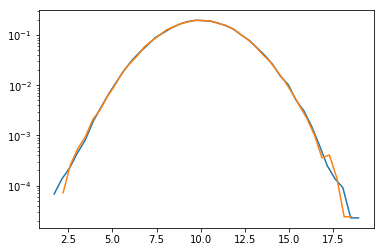

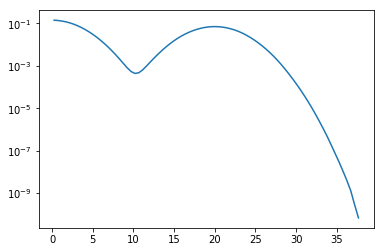

In [35]:
N = 100000
bins=40

r = np.random.normal( 10, 2, N )
Pr, xr = histogram( r, bins=bins, density=True )
t = np.random.normal( 10, 2, N )
Pt, xt = histogram( t, bins=bins, density=True )


Pc, xc = ConvolveProbabilities( [Pr,Pt], [xr,xt], log=False, shrink=True, absolute=True )

fig, ax = plt.subplots()

PlotProbability( xr, Pr, log=False, density=True, ax=ax )
PlotProbability( xt, Pt, log=False, density=True, ax=ax )
plt.yscale('log')

fig, ax = plt.subplots()

PlotProbability( xc, Pc, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)

print np.sum( Pr*np.diff(xr))
print np.sum( Pt*np.diff(xt))
print np.sum( Pc*np.diff(xc))

print Histogram2Expectation( Pr, xr, log=False )
print Histogram2Expectation( Pt, xt, log=False )
print Histogram2Expectation( Pc, xc, log=False )


1.0
1.0
1.0000255914458436
1.0
(9.994717820285887, 3.036433101602376)
(29.992747681043333, 3.1837531867156574)
(19.98628767221537, 2.9885242107558083)
(19.9904398550977, 8.834712869381494)
(59.973753173544594, 3.1145248527070915)


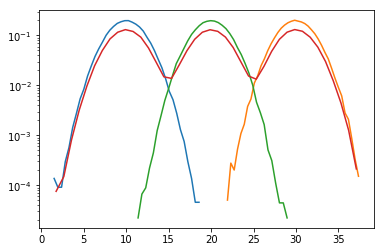

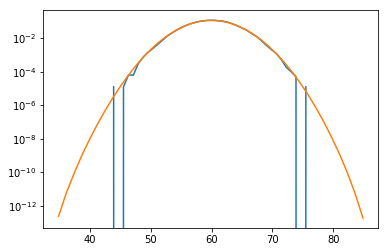

In [12]:
N = 100000
bins=40

r = np.random.normal( 10, 2, N )
Pr, xr = histogram( r, bins=bins, density=True )
t = np.random.normal( 30, 2, N )
Pt, xt = histogram( t, bins=bins, density=True )
u = np.random.normal( 20, 2, N )
Pu, xu = histogram( u, bins=bins, density=True )

#sol = np.random.normal( 20+10, np.sqrt(2**2+2**2), N )
#Psol, xsol = histogram( sol, bins=bins, density=True )
sol = np.random.normal( 20+10+30, 2*np.sqrt(3), N )
#sol = np.random.normal( 20+10+30, 9, N )
Psol, xsol = histogram( sol, bins=bins, density=True )


#pdf_c = np.convolve( pdf_r, pdf_u, mode='valid' )
#Pa, xa = AddProbability( Pr, xr, Pu, xu )
Pa, xa = AddProbabilities( [Pr, Pu,Pt], [xr, xu,xt], log=False )
Pc, xc = ConvolveProbabilities( [Pr, Pu,Pt], [xr, xu,xt], log=False, shrink=True )

fig, ax = plt.subplots()

PlotProbability( xr, Pr, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xt, Pt, log=False, density=True, ax=ax )
PlotProbability( xu, Pu, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xa, 2*Pa, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)

fig, ax = plt.subplots()

PlotProbability( xsol, Psol, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xc, Pc, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)

print np.sum( Pr*np.diff(xr))
print np.sum( Pu*np.diff(xu))

print np.sum( Pa*np.diff(xa))
print np.sum( Pc*np.diff(xc))

print Histogram2Expectation( Pr, xr, log=False )
print Histogram2Expectation( Pt, xt, log=False )
print Histogram2Expectation( Pu, xu, log=False )
print Histogram2Expectation( Pa, xa, log=False )
print Histogram2Expectation( Pc, xc, log=False )


0.9999999999999999
1.0
1.0000326770104684
1.0


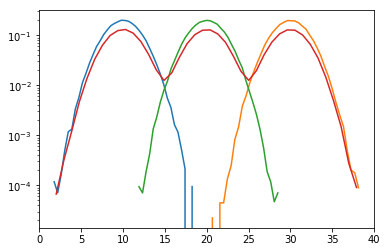

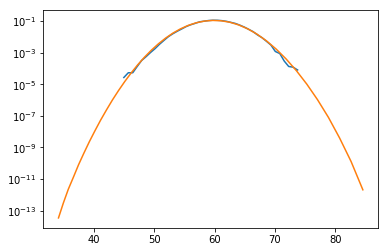

In [13]:
N = 100000
bins=40

r = np.random.normal( 10, 2, N )
Pr, xr = histogram( r, bins=bins, density=True )
t = np.random.normal( 30, 2, N )
Pt, xt = histogram( t, bins=bins, density=True )
u = np.random.normal( 20, 2, N )
Pu, xu = histogram( u, bins=bins, density=True )

sol = np.random.normal( 20+10, np.sqrt(2**2+2**2), N )
Psol, xsol = histogram( sol, bins=bins, density=True )
sol = np.random.normal( 20+10+30, np.sqrt(2**2+2**2+2**2), N )
Psol, xsol = histogram( sol, bins=bins, density=True )


#pdf_c = np.convolve( pdf_r, pdf_u, mode='valid' )
#Pa, xa = AddProbability( Pr, xr, Pu, xu )
Pa, xa = AddProbabilities( [Pr, Pu,Pt], [xr, xu,xt], log=False )
Pc, xc = ConvolveProbabilities( [Pr, Pu,Pt], [xr, xu,xt] )

fig, ax = plt.subplots()

PlotProbability( xr, Pr, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xt, Pt, log=False, density=True, ax=ax )
PlotProbability( xu, Pu, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xa, 2*Pa, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)

fig, ax = plt.subplots()

PlotProbability( xsol, Psol, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xc, Pc, log=False, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)

print np.sum( Pr*np.diff(xr))
print np.sum( Pu*np.diff(xu))

print np.sum( Pa*np.diff(xa))
print np.sum( Pc*np.diff(xc))


0.9999999999999999
1.0
1.0000092899154023


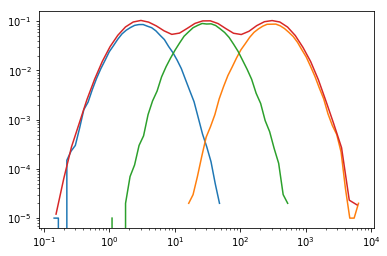

In [14]:
N = 100000
bins=40

r = np.random.lognormal( np.log(3), np.log(2), N )
Pr, xr = histogram( r, bins=bins, density=True, log=True )
t = np.random.lognormal( np.log(300), np.log(2), N )
Pt, xt = histogram( t, bins=bins, density=True, log=True )
u = np.random.lognormal( np.log(30), np.log(2), N )
Pu, xu = histogram( u, bins=bins, density=True, log=True )


Pa, xa = AddProbabilities( [Pr, Pu,Pt], [xr, xu,xt] )

fig, ax = plt.subplots()

PlotProbability( xr, Pr, log=True, density=False, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xt, Pt, log=True, density=False, ax=ax )
PlotProbability( xu, Pu, log=True, density=False, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xa, 2*Pa, log=True, density=False, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)

print np.sum( Pr*np.diff(xr))
print np.sum( Pu*np.diff(xu))

print np.sum( Pa*np.diff(xa))


1.0
0.9999999999999999
1.0001720347893595
0.9999999999999999
9.792069651703823 2.290016037613647 2.9890477590983124
29.929313790435486 2.8401742050337084 3.1379536708416893
19.908652375694594 2.741002737573851 3.1786337567149054
59.445849280409334 2.9302569824825895 3.082186841734952


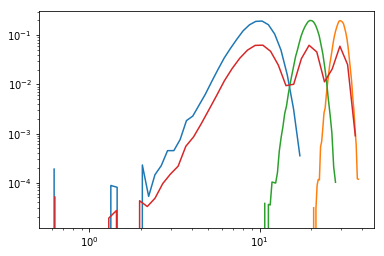

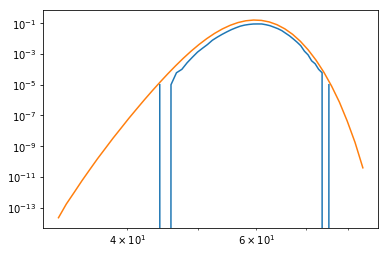

In [16]:
N = 100000
bins=40

r = np.random.normal( 10, 2, N )
Pr, xr = histogram( r, bins=bins, density=True, log=True )
t = np.random.normal( 30, 2, N )
Pt, xt = histogram( t, bins=bins, density=True, log=True )
u = np.random.normal( 20, 2, N )
Pu, xu = histogram( u, bins=bins, density=True, log=True )

sol = np.random.normal( 20+10+30, np.sqrt(2**2+2**2+2**2), N )
Psol, xsol = histogram( sol, bins=bins, density=True )

Pa, xa = AddProbabilities( [Pr, Pu,Pt], [xr, xu,xt], log=True )
Pc, xc = ConvolveProbabilities( [Pr, Pu,Pt], [xr, xu,xt] )

fig, ax = plt.subplots()

PlotProbability( xr, Pr, log=True, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xt, Pt, log=True, density=True, ax=ax )
PlotProbability( xu, Pu, log=True, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xa, Pa, log=True, density=True, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)

fig, ax = plt.subplots()

PlotProbability( xsol, Psol, log=True, density=False, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)
PlotProbability( xc, Pc, log=True, density=False, ax=ax )
plt.yscale('log')
#plt.xlim(0,50)

print np.sum( Pr*np.diff(xr))
print np.sum( Pu*np.diff(xu))

print np.sum( Pa*np.diff(xa))
print np.sum( Pc*np.diff(xc))


m, s = Histogram2Expectation( Pr, xr )
print m, m- 10.**(np.log10(m)-s), (10.**(np.log10(m)+s) -m)
m, s = Histogram2Expectation( Pt, xt )
print m, m-10.**(np.log10(m)-s), 10.**(np.log10(m)+s) -m
m, s = Histogram2Expectation( Pu, xu )
print m, m-10.**(np.log10(m)-s), 10.**(np.log10(m)+s) - m
m, s = Histogram2Expectation( Pc, xc )
print m, m-10.**(np.log10(m)-s), 10.**(np.log10(m)+s) - m


In [56]:
N = 100000
bins=40

r = np.random.lognormal( np.log(3), np.log(2), N )
Pr, xr = histogram( r, bins=bins, density=True, log=True )
t = np.random.lognormal( np.log(300), np.log(2), N )
Pt, xt = histogram( t, bins=bins, density=True, log=True )

print Histogram2Expectation( Pr, xr )
print Histogram2Expectation( Pt, xt )


(3.0101712342504596, 0.637231848256688)
(299.6497028046771, 0.06301981607251328)


In [94]:
LabelCombinedModel( **models_all )

'(primordial,astrophysical)$\\ast$(Uniform,star density,dwarf)$\\ast$(uniform/MW,uniform/dwarf,wind,wind+SNR)'

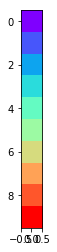

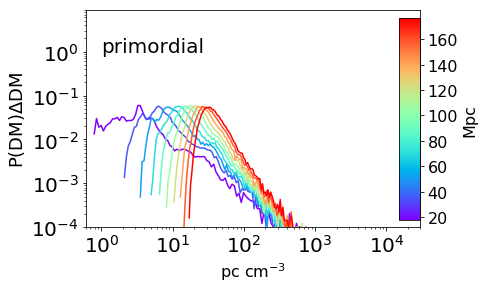

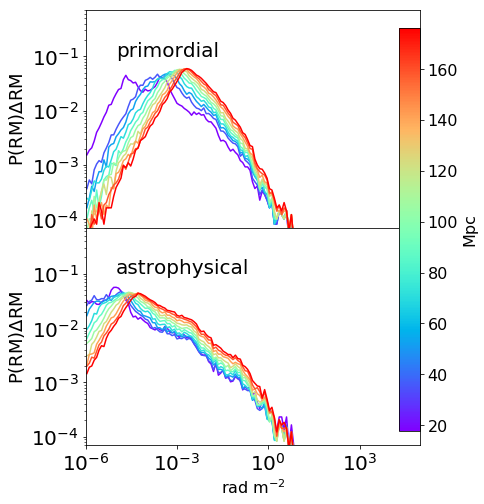

In [109]:
PlotPEvolution( full=False, dist='near')

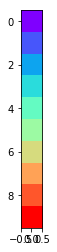

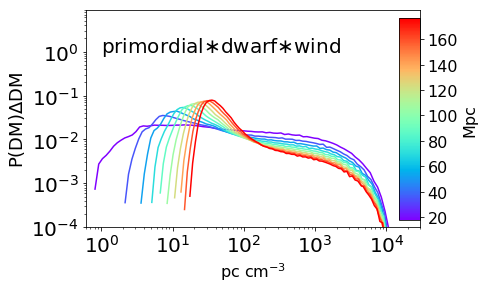

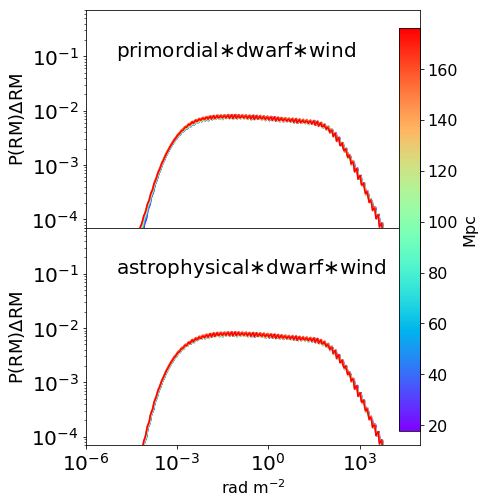

In [103]:
PlotPEvolution( full=True, dist='near')

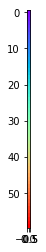

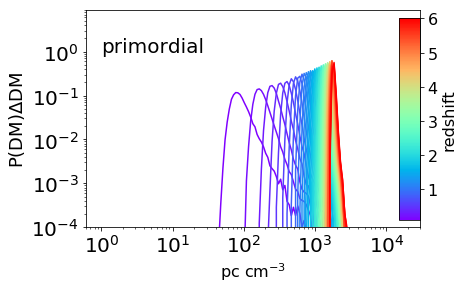

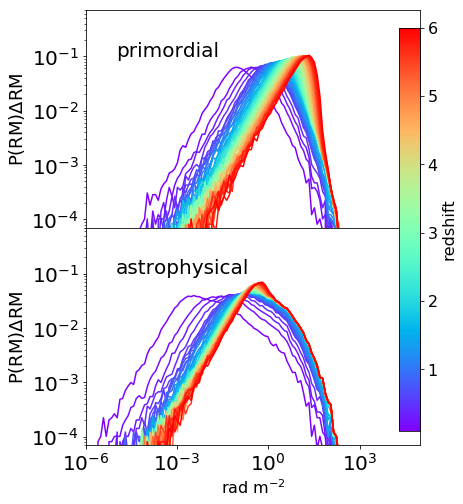

In [110]:
PlotPEvolution( full=False, dist='far')

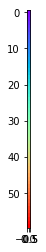

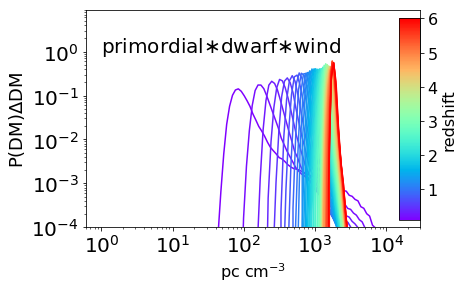

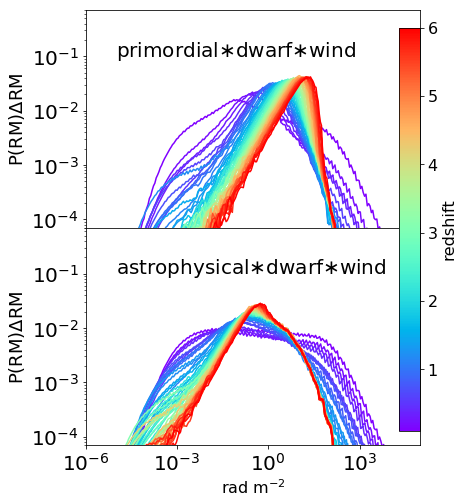

In [104]:
PlotPEvolution( full=True, dist='far')

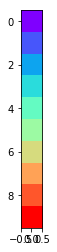

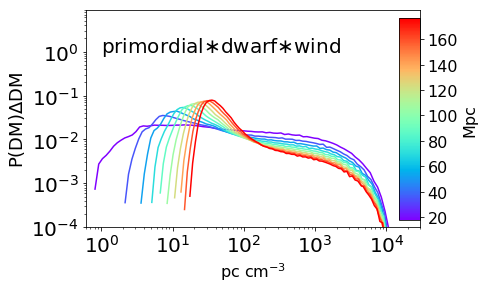

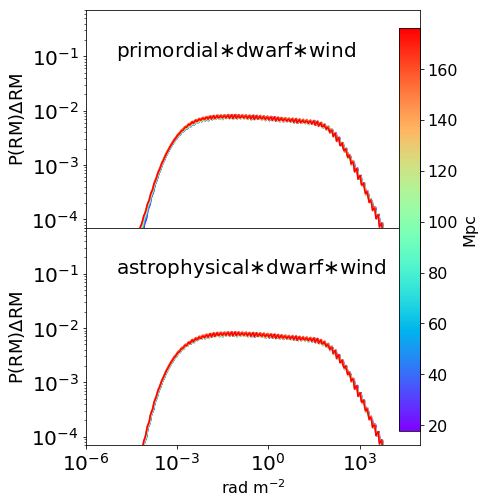

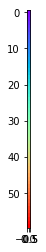

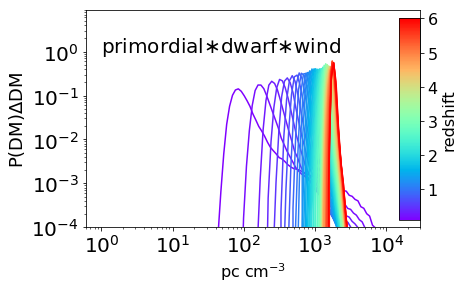

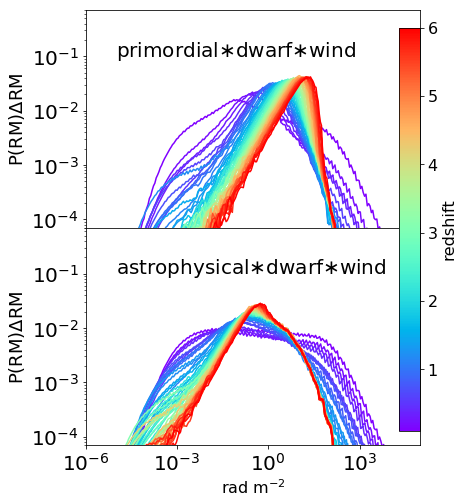

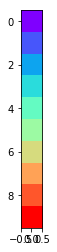

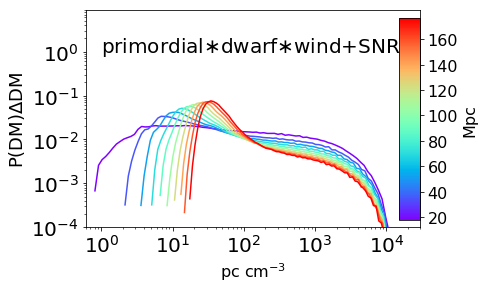

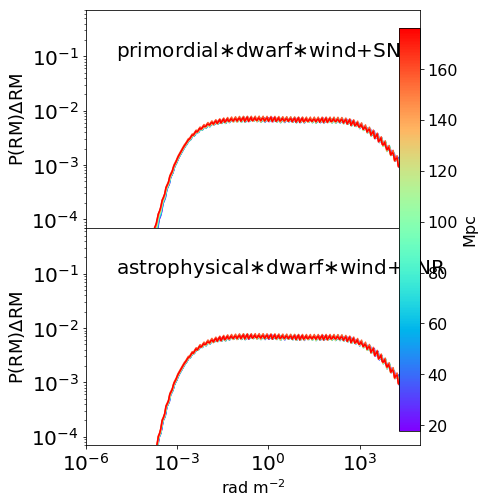

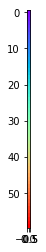

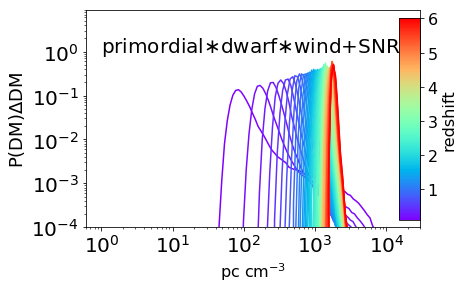

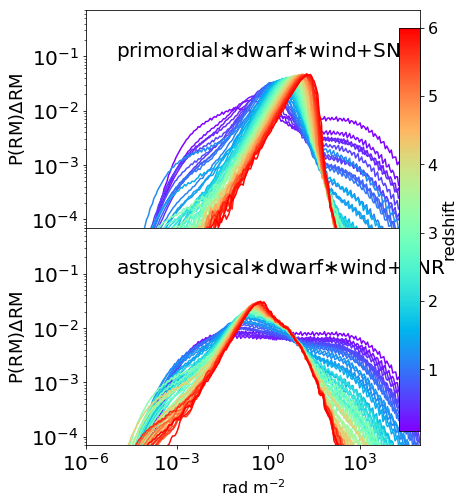

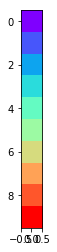

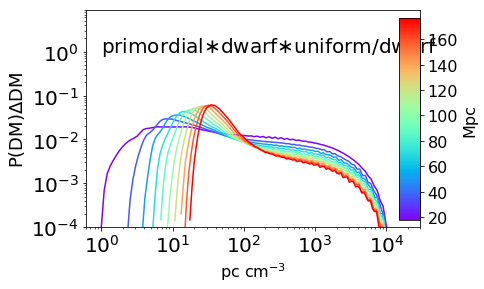

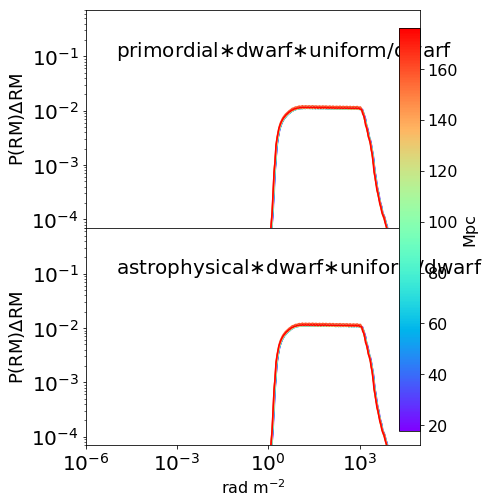

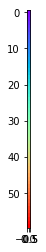

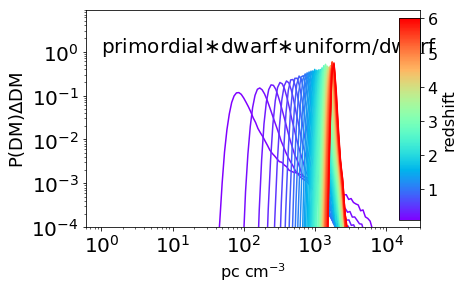

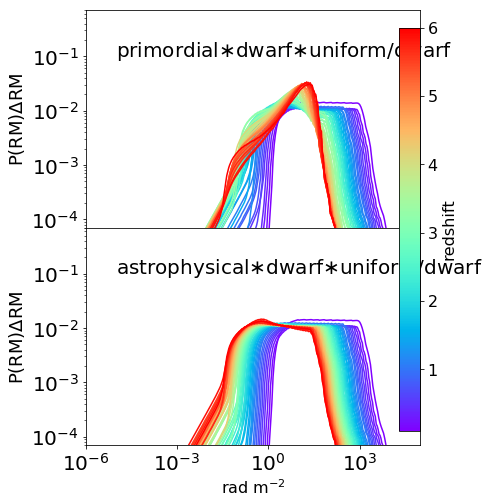

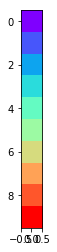

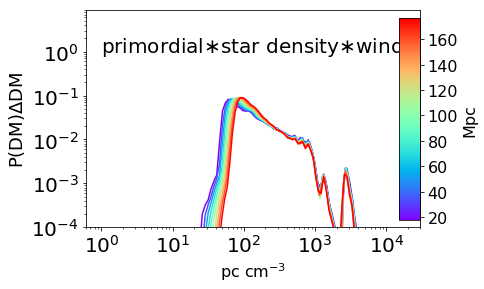

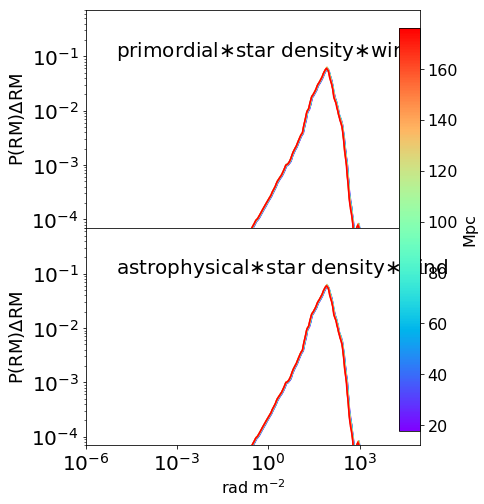

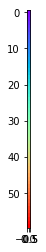

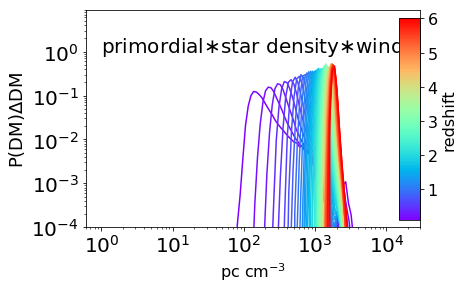

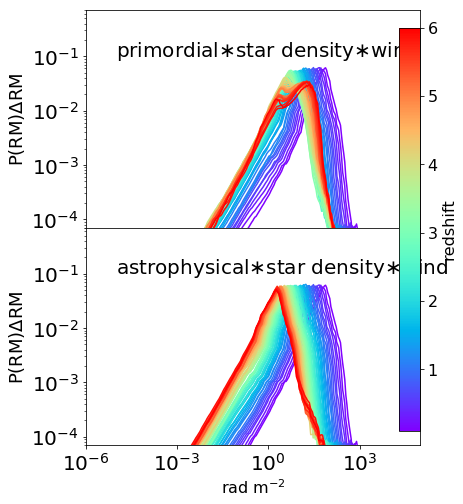

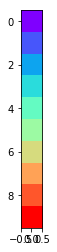

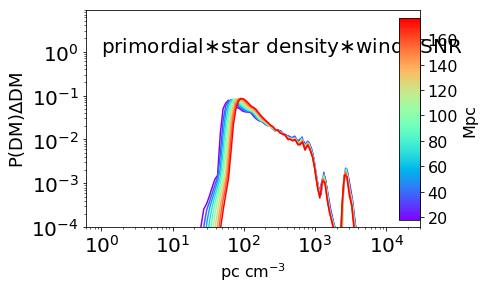

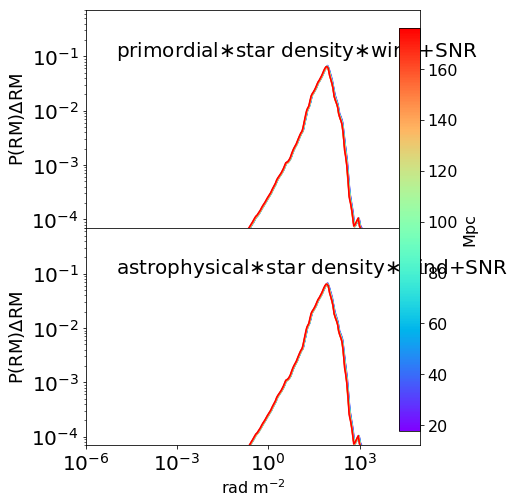

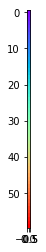

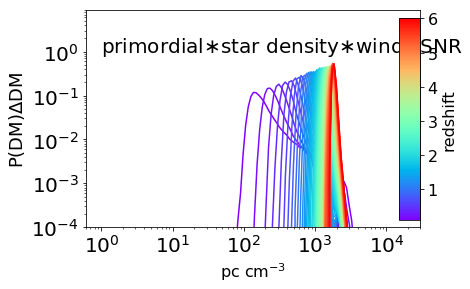

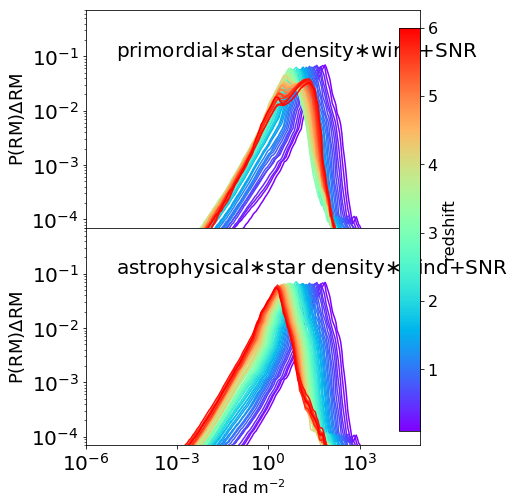

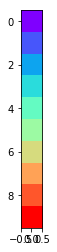

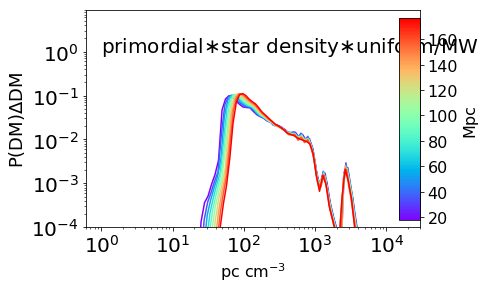

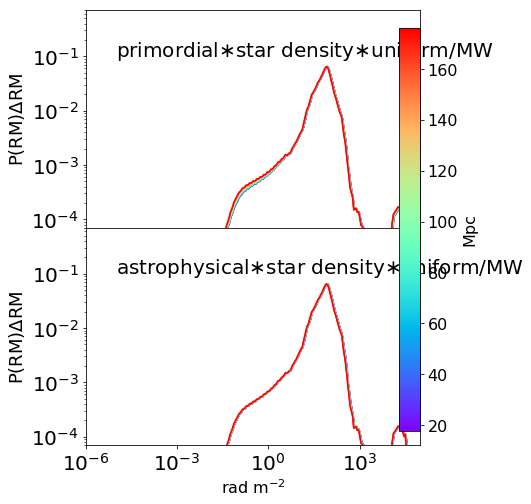

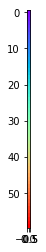

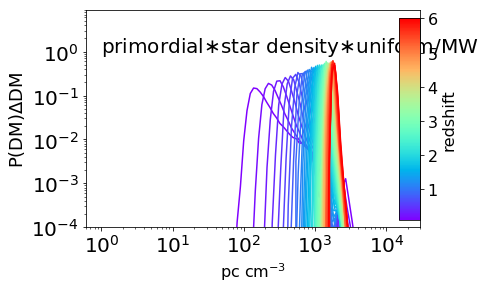

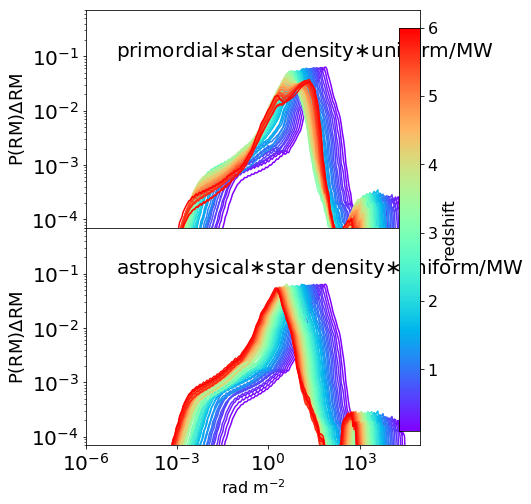

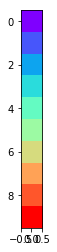

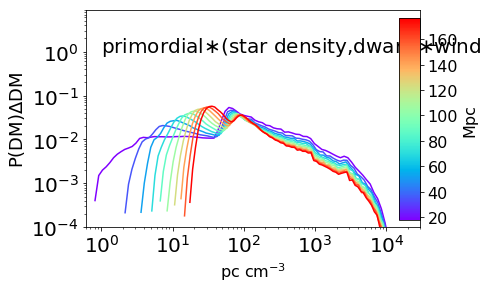

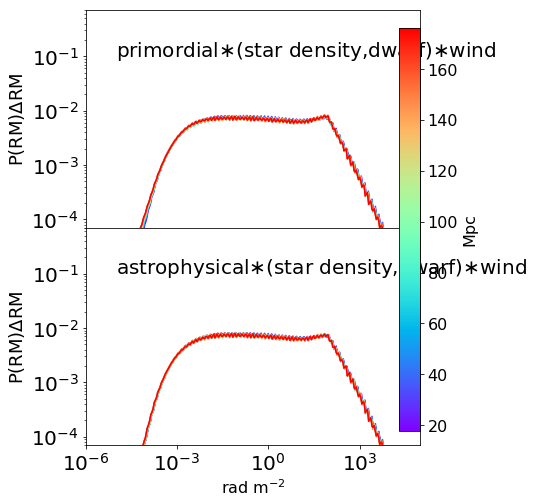

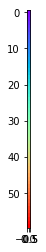

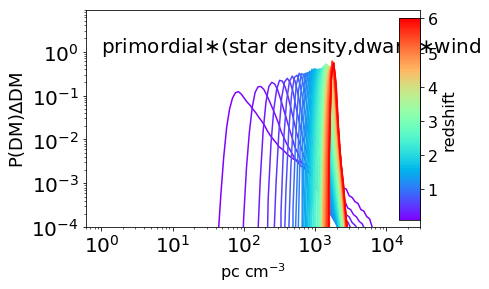

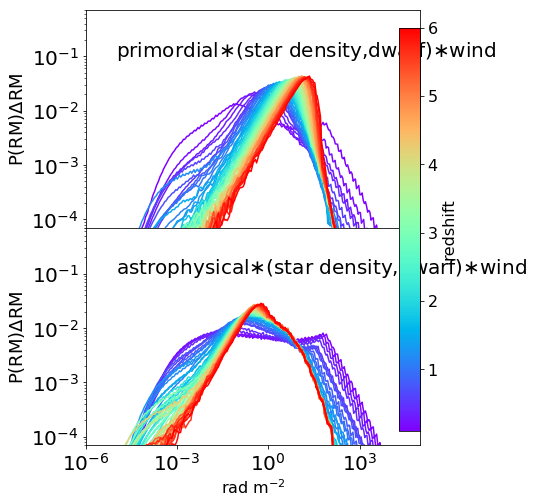

In [18]:
## !! run again
for ms in models_noIGM_sets:
    PlotPEvolution( full=True, dist='near', models_noIGM=ms)
    PlotPEvolution( full=True, dist='far', models_noIGM=ms)
    

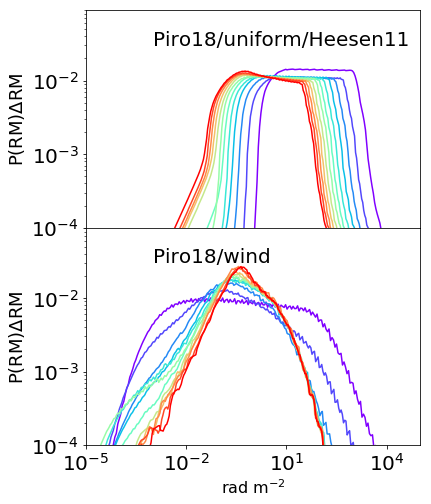

In [251]:
zs = np.linspace( 0.1, 6., 60 )[::5]
colors = cm.rainbow( np.linspace( 0, 1, len( zs ) ) )


fig, axs = plt.subplots( 2, 1, figsize=(6,8), sharex='all' )
fig.subplots_adjust( hspace=0 )
#fig, axs = plt.subplots( 1, 2, figsize=(12,4), sharey='all' )
#fig.subplots_adjust( wspace=0 )
#fig, ax = plt.subplots( figsize=(6,4) )
for i, model in enumerate( ['Piro18/uniform/Heesen11','Piro18/wind'] ):
    axs[i].text( 1e-3, 0.03, model, fontsize=20 )
    for c, z in zip( colors, zs ):
#        P, x = GetProbability( 'IGM', model, z=z, typ='RM', absolute=True, distance='far' )
        P, x = FullProbability(z=z, typ='RM', model_IGM=['astrophysical'], model_Progenitor=[model], model_Host=['Heesen11'], model_MW=[], weight_Host='dirty' )
        PlotProbability( x, P, ax=axs[i], label='z = %.1f' % z, density=False, color=c, typ='RM' )
#        PlotProbability( x, P, ax=ax, label='z = %f' % z, density=False, linestyle='-.' )
#plt.legend(loc='right')

for ax in axs:
    ax.tick_params(labelsize=20)
#    ax.set_ylabel( r"P(RM)$\Delta$RM")
    ax.set_ylim(1e-4, 0.09)
    ax.set_xlim(1e-5, 1e5)
    
#    ax.set_xlabel(r"rad m$^{-2}$")
#cb = plt.colorbar(mp )

#cb.ax.tick_params( labelsize=20 )
#cb.set_label(label='redshift',weight='bold', size=20)

plt.show()

(0.263174432069885, 1.3914671594297061)
(0.3239654906800938, 1.5742907700557995)
(0.2941812313342967, 1.0044363241050465)
(0.254475253543819, 1.5417440209614066)
(0.3757878465386501, 0.8836586237588574)
(0.20375210172525277, 1.4702520654509486)


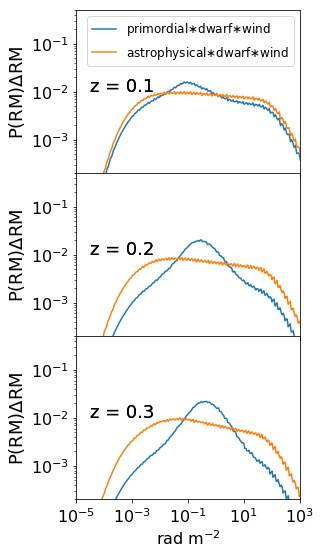

In [107]:
zs = [0.1,1.,2.,3.,4.,5.,6.][:3]#[3:6]
zs = [0.1,0.5,1.]
zs = [0.1,0.2,0.3]
#zs = np.linspace(0.1,2.0,20)[::4]
#fig, axs = plt.subplots( len(zs)/2+1, 2, figsize=(12,9) )
#fig, axs = plt.subplots( 1, len(zs), figsize=(4*len(zs),3), sharey='all' )
fig, axs = plt.subplots( len(zs), 1, figsize=(4,3*len(zs)), sharex='all' )
for ax, z in zip( axs.flatten(), zs ):
    for i, model in enumerate( ['primordial','astrophysical'] ):
        P, x = FullProbability(z=z, typ='RM', model_IGM=[model], **models_full_noIGM)
#        PlotProbability( x, P, ax=axs[i], label='z = %f' % z, density=False )
#        PlotProbability( x, P, ax=ax, label='z = %f' % z, density=False )
        label = LabelCombinedModel( model_IGM=[model], **models_full_noIGM )
        PlotProbability( x, P, ax=ax, label=label, density=False, typ='RM' )
        print Histogram2Expectation( P, x, log=True )
        ax.text( 3e-5, 1e-2, 'z = %.1f' % z, fontdict={'size':18})
        ax.set_ylim(2e-4, 0.5)
        ax.set_xlim(1e-5, 1e3)
axs[0].legend( fontsize=12) #loc='lower center')
fig.subplots_adjust( hspace=0, wspace=0 )
for ax in axs.flatten():
    ax.tick_params(labelsize=16)
  

(1.02059222880061, 0.6650613728727325)
(0.18982037984291367, 1.1340845782269542)
(2.219519806673162, 0.5747999154668256)
(0.3748079240370569, 0.8689082660060768)
(3.4049940769380056, 0.5273266469169247)
(0.40263184983383976, 0.8498081899990736)


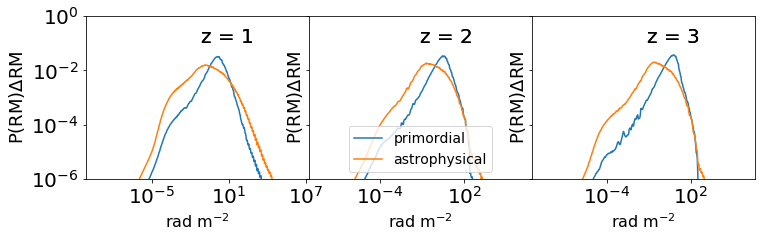

In [158]:
zs = [0.1,1.,2.,3.,4.,5.,6.][1:4]
#fig, axs = plt.subplots( len(zs)/2+1, 2, figsize=(12,9) )
fig, axs = plt.subplots( 1, len(zs), figsize=(12,3), sharey='all' )
#fig, axs = plt.subplots( len(zs), 1, figsize=(4,9), sharex='all' )
for ax, z in zip( axs.flatten(), zs ):
    for i, model in enumerate( ['primordial','astrophysical'] ):
        P, x = FullProbability(z=z, typ='RM', model_IGM=[model], **models_full_noIGM )
#        PlotProbability( x, P, ax=axs[i], label='z = %f' % z, density=False )
#        PlotProbability( x, P, ax=ax, label='z = %f' % z, density=False )
        PlotProbability( x, P, ax=ax, label=model, density=False, typ='RM' )
        print Histogram2Expectation( P, x, log=True )
        ax.text( 7e-2, 1e-1, 'z = %.0f' % z, fontdict={'size':20})
#        ax.set_ylabel( r"P(RM)$\Delta$RM")
        ax.set_ylim(1e-6, 1)
axs[1].legend(loc='lower center', prop={'size':14})
fig.subplots_adjust( hspace=0, wspace=0 )
for ax in axs:
    ax.tick_params(labelsize=20)
#    ax.set_xlabel( units['RM'] )


(8.632584432670663, 1.5291907558486277)
(51.507825518875585, 0.8255931788423321)
(0.254475253543819, 1.5417440209614066)
(2.501537590000941, 1.8694810658802212)
(5.2779690032704645, 1.5300727496767752)
(32.86757335464133, 0.8261460980248658)
(0.18543190555181782, 1.2210161735793537)
(0.9915395574214851, 1.7118124853932086)
(2.938728402942862, 1.5231999247520318)
(18.45374143406281, 0.8265070573763107)
(0.18982037984291367, 1.1340845782269542)
(0.6122001419897605, 1.5859765495600313)


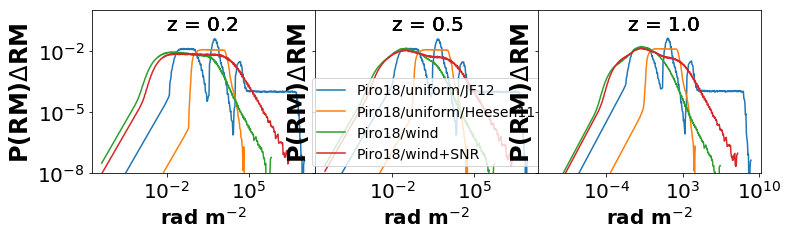

In [22]:
zs = [0.1,1.,2.,3.,4.,5.,6.][1::2]
zs = [0.2, 0.5, 1.0]
#fig, axs = plt.subplots( len(zs)/2+1, 2, figsize=(12,9) )
fig, axs = plt.subplots( 1, len(zs), figsize=(12,3), sharey='all' )
#fig, axs = plt.subplots( len(zs), 1, figsize=(4,9), sharex='all' )
for ax, z in zip( axs.flatten(), zs ):
    for i, model in enumerate( ['Piro18/uniform/JF12','Piro18/uniform/Heesen11','Piro18/wind','Piro18/wind+SNR'] ):
#    for i, model in enumerate( ['primordial','astrophysical'] ):
#        P, x = FullProbability(z=z, typ='RM', model_IGM=[model], model_MW=[])
        P, x = FullProbability(z=z, typ='RM', model_IGM=['astrophysical'], model_Progenitor=[model], model_MW=[], model_Host=['Heesen11'], weight_Host='dirty' )
#        PlotProbability( x, P, ax=axs[i], label='z = %f' % z, density=False )
#        PlotProbability( x, P, ax=ax, label='z = %f' % z, density=False )
        PlotProbability( x, P, ax=ax, label=model, density=False, typ='RM' )
        print Histogram2Expectation( P, x, log=True )
        ax.text( 1e-2, 1e-1, 'z = %.1f' % z, fontdict={'size':20})
#        ax.set_ylabel( r"P(RM)$\Delta$RM")
        ax.set_ylim(1e-8, 1)
axs[1].legend(loc='lower center', prop={'size':14})
fig.subplots_adjust( hspace=0, wspace=0 )
for ax in axs:
    ax.tick_params(labelsize=20)
#    ax.set_xlabel( units['RM'] )
  

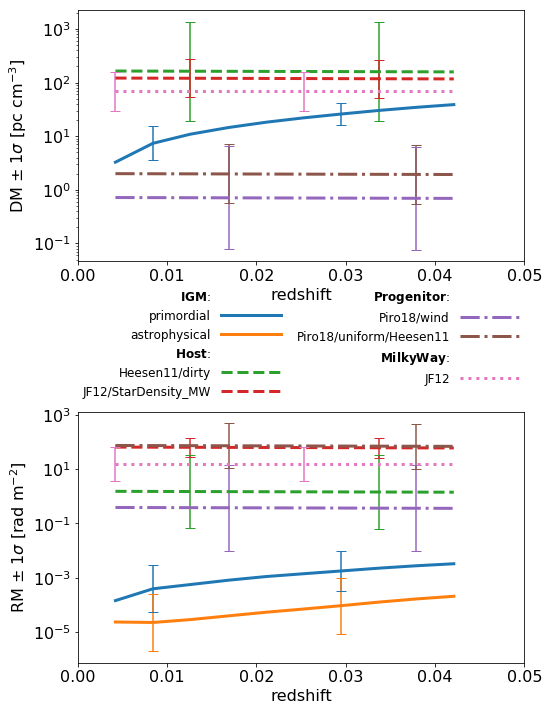

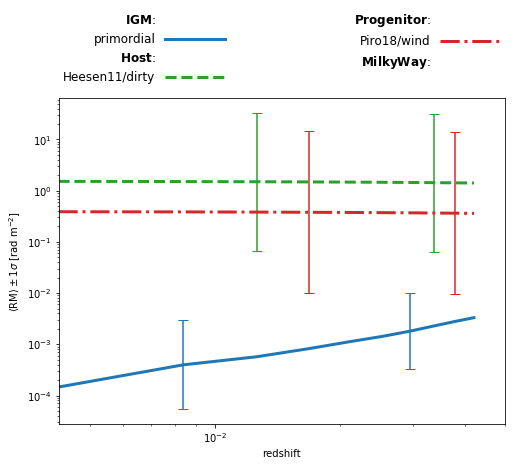

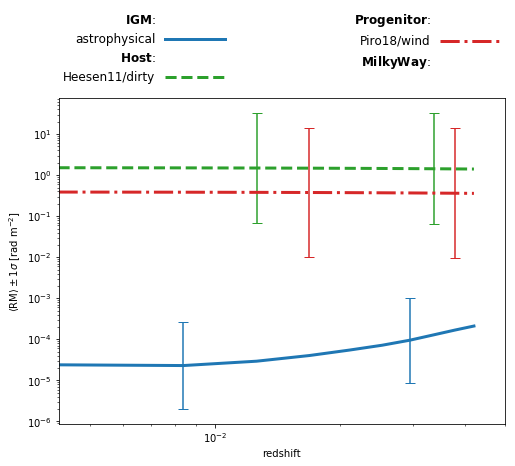

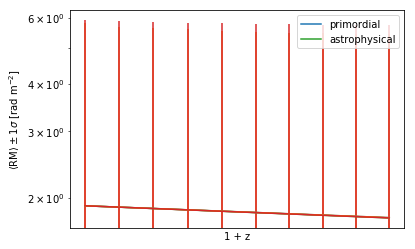

In [86]:

#plt.figure(  figsize=(8,6) )
fig, axs = plt.subplots( 2, 1, figsize=(8,12) )
plt.subplot( 2, 1, 1)
#PlotContributions( typ='DM', distance='near', model_IGM=['primordial'], model_Progenitor=['Piro18/uniform', 'Piro18/wind'][:1], errorspan=1, plot_full=True )
PlotContributions( typ='DM', distance='near', model_IGM=['primordial'], errorspan=1, plot_full=False, legend=False, **models_noIGM )
plt.tick_params( labelsize=16 )
plt.xscale('linear')
plt.xlabel( 'redshift', fontdict={'size':16})
plt.ylabel( r"DM $\pm\ 1\sigma \rm\ [ pc\ cm^{-3}]$", fontdict={'size':16} )
plt.xlim(0,0.05)
#plt.show()
#plt.figure(  figsize=(8,6) )
plt.subplot( 2, 1, 2)
PlotContributions( typ='RM', distance='near', errorspan=1, plot_full=False, legend=True, **models )
plt.xscale('linear')
plt.xlabel( 'redshift', fontdict={'size':16})
plt.ylabel( r"RM $\pm\ 1\sigma \rm\ [rad\ m^{-2}]$", fontdict={'size':16} )
plt.xlim(0,0.05)
fig.subplots_adjust( hspace=0.6)
plt.tick_params( labelsize=16 )
plt.show()
plt.figure(  figsize=(8,6) )
mean_full_prime, std_full_prime = PlotContributions( typ='RM', distance='near', model_IGM=['primordial'], errorspan=1, plot_full=False, legend=True, **models_full_noIGM )
plt.xlim(0,0.05)
plt.show()
plt.figure(  figsize=(8,6) )
mean_full_astro, std_full_astro = PlotContributions( typ='RM', distance='near', model_IGM=['astrophysical'], errorspan=1, plot_full=False, legend=True, **models_full_noIGM )
plt.xlim(0,0.05)
plt.show()

zs = np.array( h5.File( likelihood_file_IGM )['primordial/near/64/DM'].keys() ).astype('f')
plt.loglog( 1+zs, mean_full_prime, label='primordial' )
plt.errorbar( 1+zs, mean_full_prime, std_full_prime )

plt.loglog( 1+zs, mean_full_astro, label='astrophysical' )
plt.errorbar( 1+zs, mean_full_astro, std_full_astro )
plt.xlabel( '1 + z')
plt.ylabel( r"$\langle$%s$\rangle \pm 1\sigma$ [%s]" % ( 'RM', units['RM'] ) )
plt.legend()
plt.show()



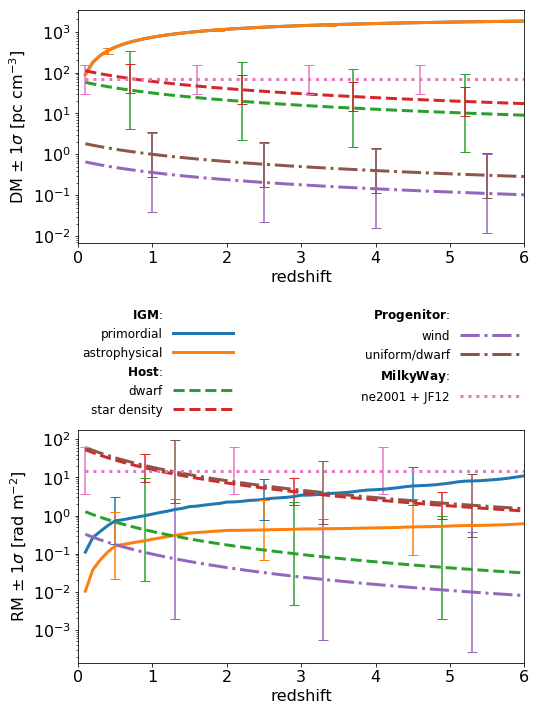

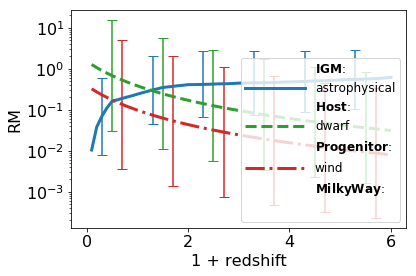

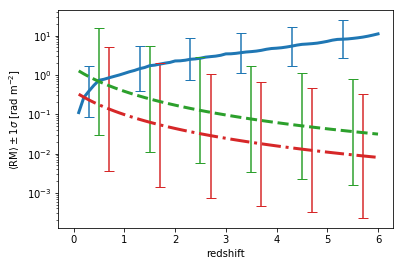

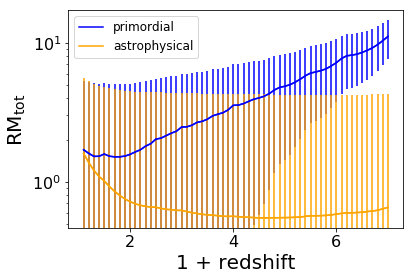

In [73]:
#plt.figure(  figsize=(8,6) )
#fig, ax = plt.subplots(  figsize=(8,6) )
fig, axs = plt.subplots( 2, 1, figsize=(8,12) )
plt.subplot( 2, 1, 1)
# model_IGM=['primordial'],
PlotContributions( typ='DM',  errorspan=3, plot_full=False, legend=False, **models ) #noIGM )
plt.xscale('linear')
plt.xlabel( 'redshift', fontdict={'size':16})
plt.ylabel( r"DM $\pm\ 1\sigma \rm\ [ pc\ cm^{-3} ]$", fontdict={'size':16} )
plt.xlim(0,6)
#plt.legend(prop={'size':12}, handlelength=5, # loc='center right',
#          bbox_to_anchor= (0.7, 1.11), 
#           ncol=2, 
#              bbox_to_anchor= (0., 1.01, 1, 0.1), loc='lower left',
#            borderaxespad=0, frameon=False, markerfirst=False, mode='expand'
#          )
plt.tick_params( labelsize=16 )
#plt.show()

#plt.figure(  figsize=(8,6) )
plt.subplot( 2, 1, 2)
PlotContributions( typ='RM', errorspan=4, plot_full=False, legend=True, **models )
plt.xscale('linear')
plt.xlabel( 'redshift', fontdict={'size':16})
plt.ylabel( r"RM $\pm\ 1\sigma \rm\ [ rad\ m^{-2} ]$", fontdict={'size':16} )
plt.xlim(0,6)

#plt.legend(prop={'size':12}, handlelength=5, # loc='center right',
#          bbox_to_anchor= (0.5, 1.11), ncol=4, 
#            borderaxespad=0, frameon=False, markerfirst=False, mode='expand')
plt.tick_params( labelsize=16 )
fig.subplots_adjust( hspace=0.8)
plt.show()


mean_full_astro, std_full_astro = PlotContributions( typ='RM', model_IGM=['astrophysical'], errorspan=2, plot_full=False, **models_full_noIGM )# , model_MW=[] )

plt.legend(prop={'size':12}, loc='lower right', handlelength=5)
plt.tick_params( labelsize=16 )
plt.xlabel( '1 + redshift', fontdict={'size':16})
plt.ylabel( 'RM', fontdict={'size':16} )

plt.xscale('linear')
plt.show()
mean_full_prime, std_full_prime = PlotContributions( typ='RM', model_IGM=['primordial'], errorspan=2, plot_full=False, **models_full_noIGM )#, model_MW=[] )
plt.xscale('linear')
plt.show()

zs = np.linspace(0.1,6.0,60)                                                                          
plt.loglog( 1+zs, mean_full_prime, label='primordial', color='blue' )
plt.errorbar( 1+zs, mean_full_prime, std_full_prime, color='blue' )

plt.loglog( 1+zs, mean_full_astro, label='astrophysical', color='orange' )
plt.errorbar( 1+zs, mean_full_astro, std_full_astro, color='orange' )
#plt.xlabel( '1 + z')
#plt.ylabel( r"$\langle$%s$_{\rm tot}\rangle \pm 1\sigma$ [%s]" % ( 'RM', units['RM'] ) )
plt.xlabel( '1 + redshift', fontdict={'size':20})
plt.ylabel( r"%s$_{\rm tot}$" % 'RM', fontdict={'size':20} )
plt.legend(prop={'size':12})
plt.tick_params( labelsize=16 )
plt.xscale('linear')
plt.show()



compare contributions probability

/data/virtualenv/crpropa_latest/local/lib/python2.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


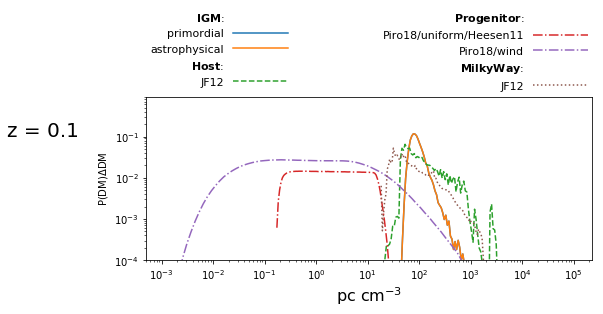

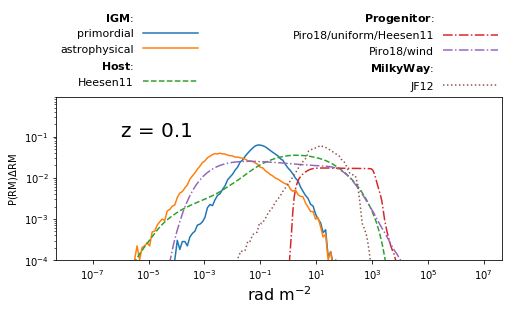

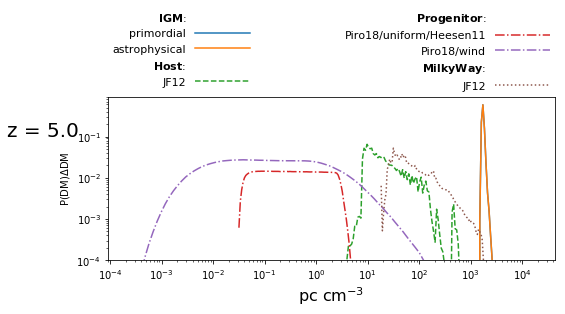

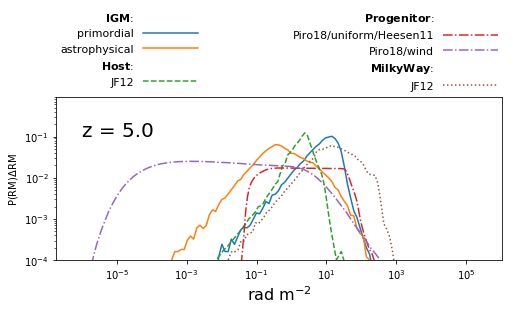

In [64]:
PlotContributorProbabilties(typ='DM', model_IGM=['primordial','astrophysical'], model_Progenitor=['Piro18/uniform/Heesen11','Piro18/wind'])
plt.show()
PlotContributorProbabilties(typ='RM', model_IGM=['primordial','astrophysical'], model_Progenitor=['Piro18/uniform/Heesen11','Piro18/wind'], model_Host=['Heesen11'], weight_Host='dirty')
plt.show()

PlotContributorProbabilties(redshift=5.0, typ='DM', model_IGM=['primordial','astrophysical'], model_Progenitor=['Piro18/uniform/Heesen11','Piro18/wind'])
plt.show()
PlotContributorProbabilties(redshift=5.0, typ='RM', model_IGM=['primordial','astrophysical'], model_Progenitor=['Piro18/uniform/Heesen11','Piro18/wind'])
plt.show()



Text(0.5,1,'RM')

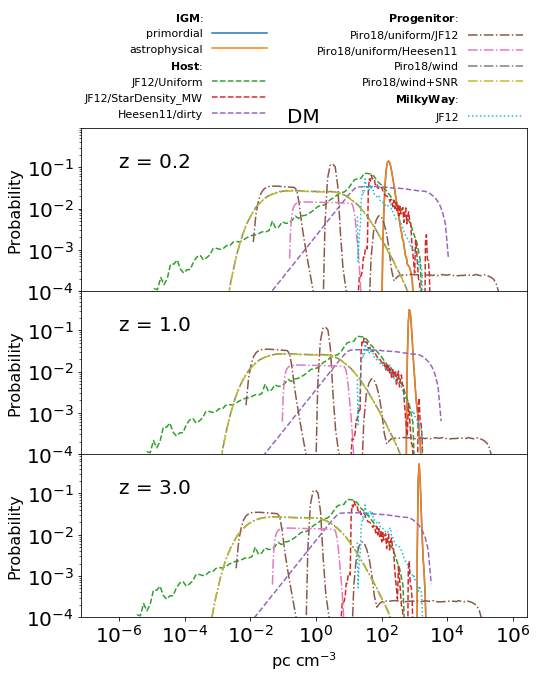

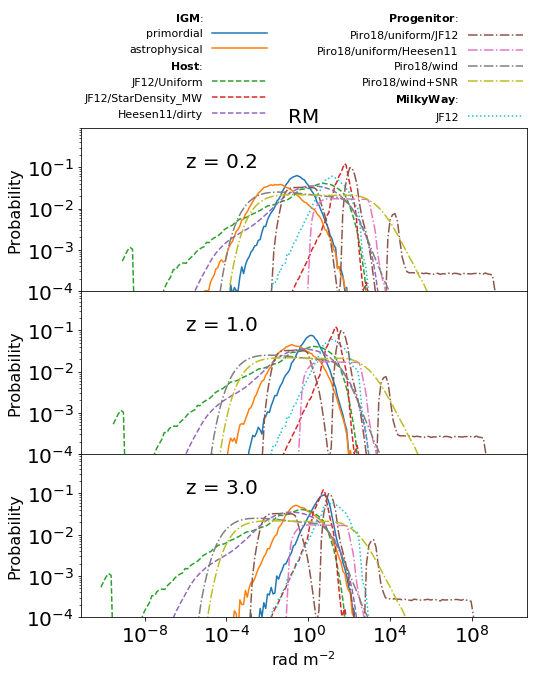

In [245]:
#fig, axs = plt.subplots( 3, 2, figsize=(16,9), sharex='col', sharey='row' )
fig0, axs0 = plt.subplots( 3, 1, figsize=(8,9), sharex='col', sharey='row' )
fig1, axs1 = plt.subplots( 3, 1, figsize=(8,9), sharex='col', sharey='row' )
kwargs = {
    'model_IGM' : ['primordial','astrophysical'],
    'model_Progenitor' : ['Piro18/uniform/JF12','Piro18/uniform/Heesen11','Piro18/wind','Piro18/wind+SNR'],
    'model_Host' : ['JF12/Uniform', 'JF12/StarDensity_MW', 'Heesen11/dirty'], 
    'weight_Host' : '',
    
}
for i, z in enumerate([0.2,1.0,3.0]):
#    PlotContributorProbabilties(redshift=z, typ='DM', ax=axs[i][0], legend=False, **kwargs )
#    PlotContributorProbabilties(redshift=z, typ='RM', ax=axs[i][1], legend=False, **kwargs)
    PlotContributorProbabilties(redshift=z, typ='DM', ax=axs0[i], legend=i==0, **kwargs )
    PlotContributorProbabilties(redshift=z, typ='RM', ax=axs1[i], legend=i==0, **kwargs)
#    PlotContributorProbabilties(typ='DM', model_IGM=['primordial','astrophysical'], model_Progenitor=['Piro18/uniform','Piro18/wind'], ax=axs[0][0], legend=True)
#    PlotContributorProbabilties(typ='RM', model_IGM=['primordial','astrophysical'], model_Progenitor=['Piro18/uniform','Piro18/wind'], model_Host=['Heesen11/IC10'], weight_Host='dirty', ax=axs[0][1])

#fig.subplots_adjust( wspace=0, hspace=0)
fig0.subplots_adjust( wspace=0, hspace=0)
fig1.subplots_adjust( wspace=0, hspace=0)
for ax in axs0.flatten():
    ax.set_ylabel( 'Probability', size=16)
    ax.tick_params(labelsize=20)
for ax in axs1.flatten():
    ax.set_ylabel( 'Probability', size=16)
    ax.tick_params(labelsize=20)
axs0[0].set_title( 'DM', size=20 )
axs1[0].set_title( 'RM', size=20 )
    

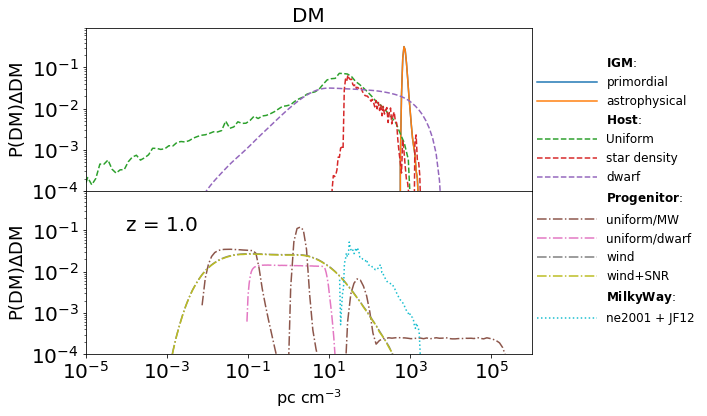

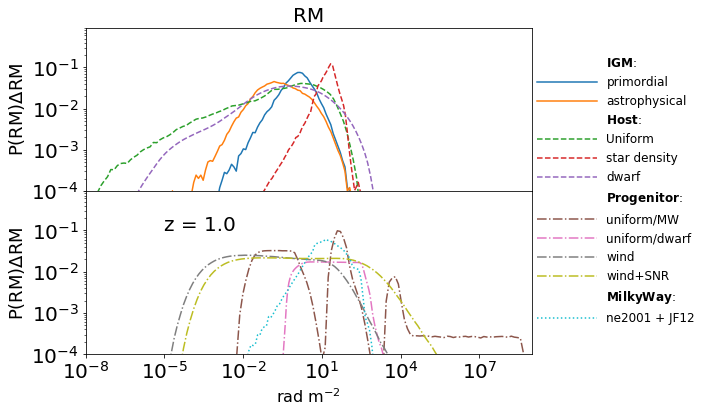

In [71]:
kwargs = {
    'model_IGM' : ['primordial','astrophysical'],
    'model_Progenitor' : ['Piro18/uniform/JF12','Piro18/uniform/Heesen11','Piro18/wind','Piro18/wind+SNR'],
    'model_Host' : ['JF12/Uniform', 'JF12/StarDensity_MW', 'Heesen11/dirty'], 
    'weight_Host' : '',
    
}

PlotContributorProbabilties_groups(redshift=1., typ='DM', legend=True, **kwargs )
PlotContributorProbabilties_groups(redshift=1., typ='RM', legend=True, **kwargs )


In [32]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(np.log(x) - np.log(mu), 2.) / (2 * np.power(sig, 2.))) / np.sqrt( 2*np.pi) / sig

def PlotGaussian( mu, sig, x_range=(1e-3,1e3) ):
    x_values = np.linspace( *x_range, num=100)
    plt.plot(x_values, gaussian(x_values, mu, sig))


In [ ]:
ms, ss = [], []
zs = np.linspace( 0.1, 6.0, 60 )
for z in zs[::10]:
#    P, x = FullProbability( typ='RM', model_IGM=['astrophysical'], z=z )
    P, x = GetProbability_IGM( typ='RM', model='astrophysical', z=z )
#    PlotProbability( x, P )
    m, s = Histogram2Expectation( P, x )
    ms.append( m )
    ss.append( ss )
    print z
#    PlotGaussian( m, s )
#    plt.ylim(1e-6,1 )
#    plt.show()
    
#    print z, m, s, '    \t', 10.**( np.log10(m) - s ), 10.**( np.log10(m) + s )
errorbar( 1+zs, ms, ss )

(0.0001, 0.1)

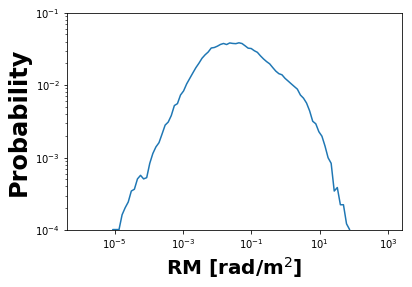

In [26]:
P, x = GetProbability_IGM( typ='RM', model='astrophysical', z=0.2 )
PlotProbability( x, P, typ='RM' )
plt.ylim(1e-4,1e-1)

In [19]:
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5._hl.group.Group,h5._hl.files.File]:
        for key in obj.keys():
            print sep,'-',key,':',obj[key]
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print sep+'\t','-',key,':',obj.attrs[key]

def h5dump(path,group='/'):
    """
    print HDF5 file metadata

    group: you can give a specific group, defaults to the root group
    """
    with h5.File(path,'r') as f:
         descend_obj(f[group])

In [43]:
h5dump( 'data/FRB/DMRMprobability_IGM.h5')

	- astrophysical : <HDF5 group "/astrophysical" (2 members)>
		- far : <HDF5 group "/astrophysical/far" (1 members)>
			- 64 : <HDF5 group "/astrophysical/far/64" (3 members)>
				- DM : <HDF5 group "/astrophysical/far/64/DM" (60 members)>
					- 0.1000 : <HDF5 group "/astrophysical/far/64/DM/0.1000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0.2000 : <HDF5 group "/astrophysical/far/64/DM/0.2000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0.3000 : <HDF5 group "/astrophysical/far/64/DM/0.3000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0.4000 : <HDF5 group "/astrophysical/far/64/DM/0.4000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
				

						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 4.6000 : <HDF5 group "/astrophysical/far/64/RM/4.6000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 4.7000 : <HDF5 group "/astrophysical/far/64/RM/4.7000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 4.8000 : <HDF5 group "/astrophysical/far/64/RM/4.8000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 4.9000 : <HDF5 group "/astrophysical/far/64/RM/4.9000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 5.0000 : <HDF5 group "/astrophysical/far/64/RM/5.0000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8"

						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 4.7000 : <HDF5 group "/primordial/far/64/DM/4.7000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 4.8000 : <HDF5 group "/primordial/far/64/DM/4.8000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 4.9000 : <HDF5 group "/primordial/far/64/DM/4.9000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 5.0000 : <HDF5 group "/primordial/far/64/DM/5.0000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 5.1000 : <HDF5 group "/primordial/far/64/DM/5.1000" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 5.2000

						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0.0169 : <HDF5 group "/primordial/near/64/RM/0.0169" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0.0211 : <HDF5 group "/primordial/near/64/RM/0.0211" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0.0253 : <HDF5 group "/primordial/near/64/RM/0.0253" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0.0295 : <HDF5 group "/primordial/near/64/RM/0.0295" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0.0337 : <HDF5 group "/primordial/near/64/RM/0.0337" (2 members)>
						- P : <HDF5 dataset "P": shape (100,), type "<f8">
						- x : <HDF5 dataset "x": shape (101,), type "<f8">
					- 0

In [23]:
key = 'primordial/near/64/DM/'
with h5.File('data/DMRMmap.h5') as f:
    for k in f[key].keys():
        print f[key+k].value.max()
#        f[key+k][...] *= 1e6
        print f[key+k].value.max()
        

1280.8043050654023
1280.8043050654023
1289.2247883021923
1289.2247883021923
1293.0798114781169
1293.0798114781169
1295.9860194621608
1295.9860194621608
1298.67490351307
1298.67490351307
1301.0262908797054
1301.0262908797054
1330.1007688661339
1330.1007688661339
1341.8159795367949
1341.8159795367949
1345.5229403886794
1345.5229403886794
1346.8811533915161
1346.8811533915161


In [ ]:
h5dump( '/hummel/FRB/DMRMrays.h5' )

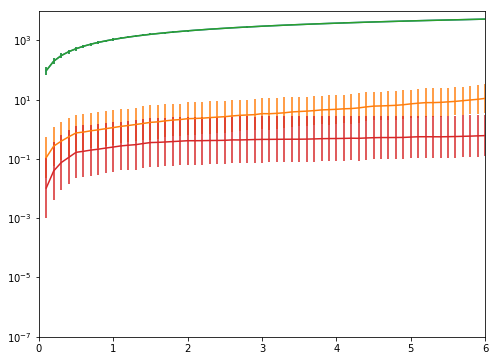

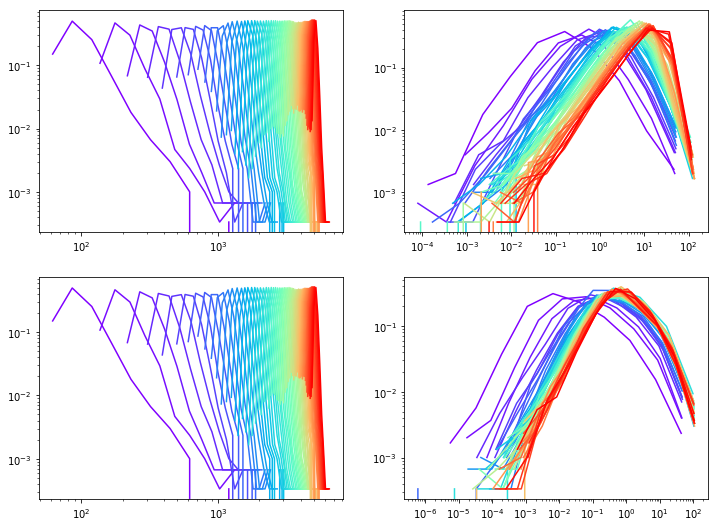

In [83]:
plt.figure( figsize=(8,6) )
zs = np.linspace( 0.1, 6.0, 60 )
DM = [[],[]]
RM = [[],[]]
with h5.File( 'data/FRB/DMRMrays.h5' ) as f:
    for i,k0 in enumerate(f.keys()[::-1]):
        for k1 in f[k0].keys():
            key = '/'.join([k0,k1])
            for k2 in f[key].keys()[:3000]:
                key = '/'.join([k0,k1,k2])
                for k3 in f[key]:
                    key = '/'.join([k0,k1,k2,k3])
                    if k3 == 'DM':
                        DM[i].append( np.abs(np.cumsum(f[key].value)) )
#                        plt.plot( zs[:60], DMs[i][-1][:60], color='blue' if k0=='primordial' else 'red', linewidth=0.3  )
                    else:
                        RM[i].append( np.abs(np.cumsum(f[key].value)) )
#                        plt.plot( zs[:60], RMs[i][-1][:60], color='blue' if k0=='primordial' else 'red', linewidth=0.3  )
'''                    
plt.yscale('log')
plt.gca().invert_xaxis()
plt.ylim(1e-7,1e4)
plt.xlim(1,0)
plt.show()
#'''
DMs= np.log10(DM)
RMs= np.log10(RM)

DMs_ = np.average( DMs, axis=1 )
RMs_ = np.average( RMs, axis=1 )
DMs_std = np.std( DMs, axis=1 )
RMs_std = np.std( RMs, axis=1 )
DMs__ = 10.**DMs_
DMs_lo = DMs__ - 10.**( DMs_ - DMs_std )
DMs_hi = 10.**( DMs_ + DMs_std ) - DMs__
RMs__ = 10.**RMs_
RMs_lo = RMs__ - 10.**( RMs_ - RMs_std )
RMs_hi = 10.**( RMs_ + RMs_std ) - RMs__

for i in [0,1]:
    plt.errorbar( zs, DMs__[i], [DMs_lo[i],DMs_hi[i]] )
    plt.errorbar( zs, RMs__[i], [RMs_lo[i],RMs_hi[i]] )
plt.yscale('log')
plt.gca().invert_xaxis()
plt.ylim(1e-7,1e4)
plt.xlim(1,0)
plt.xlim(0,6)
plt.show()

DM, RM = np.array( [DM, RM] )

color = cm.rainbow( np.linspace( 0, 1, len( zs ) ) )

fig, axs = plt.subplots( 2,2, figsize=(12,9) )
for i in range(2):
    for i_z, (c,z) in enumerate( zip( color, zs ) ):
        P, x = histogram( DM[i,:,i_z], log=True, density=True)
        PlotProbability( x, P, ax=axs[i][0], color=c )
        P, x = histogram( RM[i,:,i_z], log=True, density=True )
        PlotProbability( x, P, ax=axs[i][1], color=c )
    
    

In [61]:
np.sort?

model Likelihood

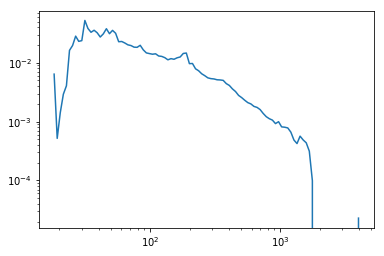

In [44]:
P, x = GetProbability( 'MilkyWay', model='JF12', typ='DM', density=False )
PlotProbability( x, P, density=True )

fake test group

(0.6912064203985829, 0.7146065431925174)
(0.18543190555181782, 1.2210161735793537)


'\nbins=100\nfor N in [1000000]:\n    a = np.random.lognormal( np.log(1.677), 0.95, N )\n    Pa, xa = histogram( a, bins=bins, density=True, log=True )\n    PlotProbability( xa, Pa, ax=ax, label=model, density=False )\n    print Histogram2Expectation( Pa, xa, log=True )\n\n    p = np.random.lognormal( np.log(13), 0.7, N )\n    Pp, xp = histogram( p, bins=bins, density=True, log=True )\n    PlotProbability( xp, Pp, ax=ax, label=model, density=False )\n    print Histogram2Expectation( Pp, xp, log=True )\n'

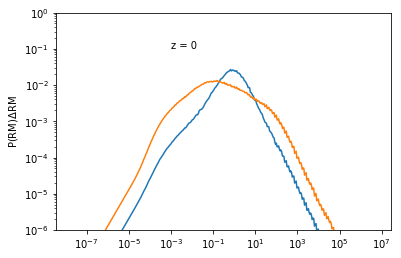

In [78]:
fig, ax = plt.subplots()
z = 0.5

for model in ['primordial', 'astrophysical']:
    P, x = FullProbability(z=z, typ='RM', model_IGM=[model], weight_Host='', density=True, **models_full_noIGM)
    PlotProbability( x, P, ax=ax, label=model, density=False )
    print Histogram2Expectation( P, x, log=True )
ax.text( 1e-3, 1e-1, 'z = %.0f' % z)
ax.set_ylabel( r"P(RM)$\Delta$RM")
ax.set_ylim(1e-6, 1)

'''
bins=100
for N in [1000000]:
    a = np.random.lognormal( np.log(1.677), 0.95, N )
    Pa, xa = histogram( a, bins=bins, density=True, log=True )
    PlotProbability( xa, Pa, ax=ax, label=model, density=False )
    print Histogram2Expectation( Pa, xa, log=True )

    p = np.random.lognormal( np.log(13), 0.7, N )
    Pp, xp = histogram( p, bins=bins, density=True, log=True )
    PlotProbability( xp, Pp, ax=ax, label=model, density=False )
    print Histogram2Expectation( Pp, xp, log=True )
'''

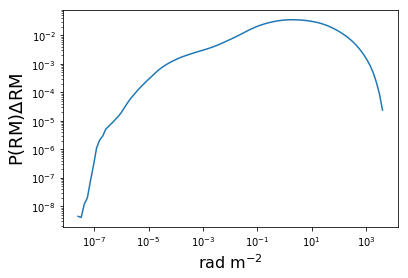

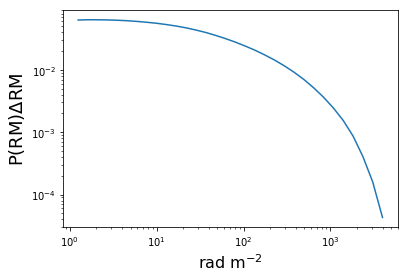

In [27]:
P, x = FullProbability( typ='RM', **s_Host )
PlotProbability( x, P, typ='RM')
P, x = ObservableProbability( min=1., typ='RM', **s_Host )
PlotProbability( x, P, typ='RM')


In [34]:
### fake test
z=1.5
#fig, axs = plt.subplots(3,1, figsize=(4,9))
#ax = axs[2]

def FakeTest( P_DM, x_DM, P_RM, x_RM, model1, model2, N=10**2, N_check=6 ):
    
#    ## load probability density function of combined DM and RM 
#    P_DM, x_DM = FullProbability(z=z, typ='DM', density=True, **models )
#    P_RM, x_RM = FullProbability(z=z, typ='RM', density=True, **models )
    
    ## -> probability = P*dx
    Pd_DM = P_DM*np.diff( x_DM )
    Pd_RM = P_RM*np.diff( x_RM )
    
    ## due to the ionosphere foreground, only allow for RM > 1 rad m^-2
    '''
    RM_min = 1 # rad m^-2
    x_RM_observable, = np.where( x_RM > RM_min )
    x_RM = x_RM[ x_RM_observable ]
    Pd_RM = Pd_RM[ x_RM_observable[:-1] ]
    Pd_RM /= np.sum( Pd_RM )  # renormalize to 1
    '''
    
    B_check = []  ## container for solutions of N_check samples
    for i_check in range( N_check ):
    
    ##   sample probaility function
        DM = RandomSample( N, Pd_DM, x_DM )
        RM = RandomSample( N, Pd_RM, x_RM )
    
    ##   compute and collect the Bayes factor
        B_check.append( CombinedBayesFactor( DM, RM, model1=model1, model2=model2 ) )
    
    ## calculate the log-mean and stddev of B in the samples
    B_check = np.log10(B_check)
    B = 10.**np.average( B_check )
    B_std = np.std( B_check )
    
    ## for the last sample, also calculate the log-mean and stdddev of RM
    RM_log = np.log10( RM )
    RM = 10.**np.average( RM_log )
    RM_std  = np.std( RM_log )

    return B, B_std, RM, RM_std
    

def PlotFakeTest( z=1.0, ax=None, Ns=(10**np.linspace( 0.5,2.5, 10)).astype('i'), axs=None, models_full_noIGM=models_full_noIGM ):
    ## models to compare with Bayes factor
    model1 = dict( models_full_noIGM )
    model2 = dict( models_full_noIGM )
    model1['model_IGM'] = 'primordial'
    model2['model_IGM'] = 'astrophysical'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,3) )
#        fig, axs = plt.subplots(1,3, figsize=(12,3) )
#        ax = axs[2]
    ax.loglog()
    for i, model in enumerate( ['primordial', 'astrophysical'] ):
#        P_DM, x_DM = FullProbability(z=z, typ='DM', model_IGM=[model], density=True, **models_full_noIGM)
#        P_RM, x_RM = FullProbability(z=z, typ='RM', model_IGM=[model], density=True, **models_full_noIGM)
        P_DM, x_DM = ObservableProbability(z=z, typ='DM', model_IGM=[model], density=True, **models_full_noIGM)
        P_RM, x_RM = ObservableProbability(z=z, typ='RM', model_IGM=[model], density=True, **models_full_noIGM)
#        Pd_DM = P_DM*np.diff(x_DM)
#        Pd_RM = P_RM*np.diff(x_RM)
        
#        PlotProbability( x_DM, P_DM, ax=axs[0], typ='DM' )
#        PlotProbability( x_RM, P_RM, ax=axs[1], typ='RM' )
        mean, std, B, B_std = [], [], [], []
#        for i_N in trange( len(Ns) ):
#            N = Ns[i_N]
        for N in Ns:
            b, b_std, rm, rm_std = FakeTest( P_DM, x_DM, P_RM, x_RM, model1, model2, N=N, N_check=6 )
            B.append(b)
            B_std.append(b_std)
            mean.append(rm)
            std.append(rm_std)
        
            '''
            B_check = []
            for i_check in range(6):
                DM = RandomSample( N, Pd_DM, x_DM )
                RM = RandomSample( N, Pd_RM, x_RM )
                B_check.append( CombinedBayesFactor( DM, RM, model1=model1, model2=model2 ) )
#                B_check.append( CombinedBayesFactor( DM, RM, model1={'model_IGM':['primordial']}, model2={'model_IGM':['astrophysical']} ) )
            B_check = np.log10(B_check)
            B.append( 10.**np.average( B_check ) )
            B_std.append( np.std( B_check ) )
            
            
#            P, x = histogram( DM, bins=100, range=(x_DM[0],x_DM[-1]), density=True, log=True  )
#            PlotProbability( x, P, ax=axs[0], linestyle='--' )
            P, x = histogram( RM, bins=100, range=(x_RM[0],x_RM[-1]), density=True, log=True  )
#            PlotProbability( x, P, ax=axs[1], linestyle=':' )
        
            RM_log = np.log10(RM)
            mean_RM = 10.**np.average( RM_log )
            std_RM  = np.std( RM_log )
            mean.append( mean_RM )
            std.append( std_RM )
            '''
        
        std = np.array(std).transpose()

#        errorbar( Ns, B, B_std, label='BayesFactor '+model, line=True )
        errorbar( Ns, B, B_std, label='B       '+model, line=True )
        errorbar( Ns*(10.+i)/10, mean, std, label=r"$\langle RM \rangle$ "+model, line=True, linestyle='-.' )
    

    #ax.text( ax.get_xlim()[0]*3, ax.get_ylim()[-1]*0.5, "z = %.1f" % z, fontdict={'size':  20})#  12} )
    ax.set_title( "z = %.1f" % z, fontdict={'size':  20} )
    
    ax.set_xlabel( 'N', fontdict={'size':16} )
    ax.set_ylabel( r"$\langle RM \rangle$, Bayes Factor", fontdict={'size':16} )
    ax.legend( handlelength=5 )
    ax.tick_params(labelsize=14)

    
#    axs[0].set_ylim(1e-4,1)
#    axs[1].set_ylim(1e-4,1)


720.6 seconds


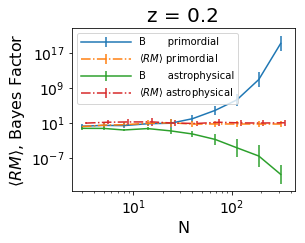

In [36]:
t = time()
PlotFakeTest( 0.2 )
print "%.1f seconds" % (time() - t)


835.8 seconds


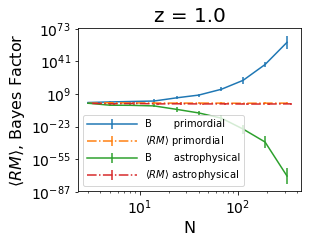

In [118]:
t = time()
PlotFakeTest( 1.0 )
print "%.1f seconds" % (time() - t)


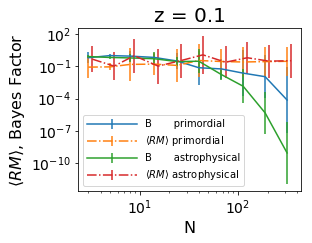

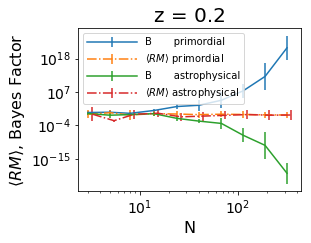

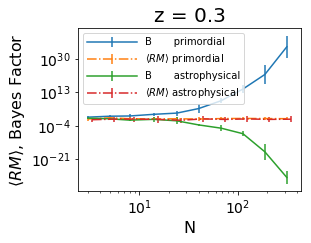

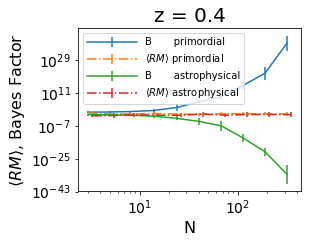

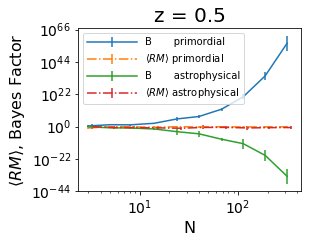

In [282]:
#fig, axs = plt.subplots( 3,2, figsize=(12,6) )
#axs = axs.flatten()
zs = [1.,1.1,1.2,1.3,1.4,1.5]
zs = [0.1,0.2,0.3,0.4,0.5]
for iz, z in enumerate(zs):
    PlotFakeTest( z )

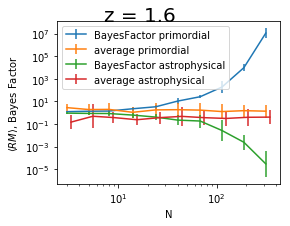

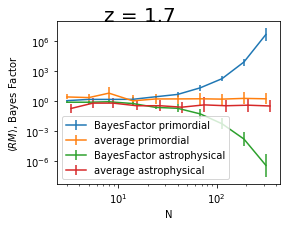

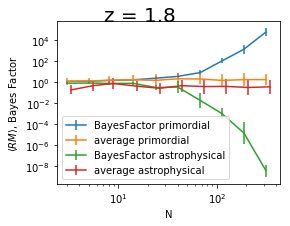

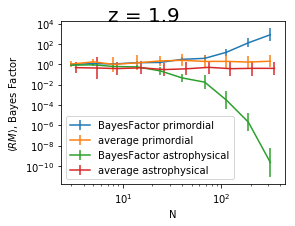

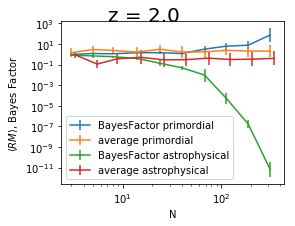

In [12]:
#fig, axs = plt.subplots( 3,2, figsize=(12,6) )
#axs = axs.flatten()
zs = [0.1,0.2,0.3]
for iz, z in enumerate(zs):
    PlotFakeTest( z )

find demarcing redshift for each set of models

In [15]:
import itertools
def get_steps( N, x, log=False):                                                                                                                                                                            
    ''' calculate N equal (logarithmic) steps from x[0] to x[1] '''                                                                                                                                         
    if log:                                                                                                                                                                                                 
        xx = np.log10(x)                                                                                                                                                                                    
    else:                                                                                                                                                                                                   
        xx = x                                                                                                                                                                                              
    x_step = np.linspace( xx[0], xx[1], N)                                                                                                                                                                  
    if log:                                                                                                                                                                                                 
        x_step = 10.**x_step                                                                                                                                                                                
    return x_step 

def mean( x, log=False, **kwargs ):                                                                                                                                                                         
    if log:                                                                                                                                                                                                 
        return 10.**np.mean( np.log10( x ), **kwargs )                                                                                                                                                      
    else:                                                                                                                                                                                                   
        return np.mean( x, **kwargs )                                                                                                                                                                       
                                                                                                                                                                                                            
def coord2normal(x, lim, log=False):                                                                                                                                                                        
    ''' transforms coordinate x in (logarithmic) plot to normal coordinates (0,1) '''                                                                                                                       
    if log:                                                                                                                                                                                                 
        return (np.log(x) - np.log(lim[0]))/(np.log(lim[1]) - np.log(lim[0]))                                                                                                                               
    else:                                                                                                                                                                                                   
        return ( x - lim[0] )/( lim[1] - lim[0] )                                                                                                                                                           


def plot_limit( ax, x, y, limit, xlim, ylim, value='', xlog=False, ylog=False, arrow_number=2, arrow_length=0.1, arrow_width=0.005, linewidth=4, shift_text_vertical=0, shift_text_horizontal=0 ):          
    limit_x, limit_y = int( x[1] == x[0] ), int( y[1] == y[0] )                                                                                                                                             
    upper = 1 - 2 * int( limit=='lower' )  # 1 for upper limit, -1 for lower                                                                                                                                
    kwargs = { 'alpha' : 0.7, 'color' : 'gray'}                                                                                                                                                             
    plot, = ax.plot( x, y, linestyle='-.', linewidth=linewidth, **kwargs)                                                                                                                                    
    plot.set_dashes([15,5,3,5])                                                                                                                                                                              
    ax.text(                                                                                                                                                                                                
        mean(x, log=xlog) + shift_text_horizontal, mean(y, log=ylog) + shift_text_vertical,                                                                                                                 
#        np.mean(y) + upper * limit_x * shift_text_vertical + limit_y * shift_text_horizontal,                                                                                                              
        value, fontsize=14, rotation= -90 * limit_x * upper,                                                                                                                                                
        verticalalignment='center', horizontalalignment='center', color=kwargs['color'])                                                                                                                    
    x_ar, y_ar = get_steps( arrow_number + 2, x, log=xlog)[1:-1], get_steps( arrow_number + 2, y, log=ylog)[1:-1]                                                                                           
    x_length, y_length = - upper * arrow_length * limit_x, - upper * arrow_length * limit_y                                                                                                                 
#    for xa, ya in itertools.izip( x_ar, y_ar ):                                                                                                                                                            
#        ax.arrow( xa, ya, x_length, y_length, width=arrow_width, **kwargs )                                                                                                                                
    for xa, ya in itertools.izip( coord2normal( x_ar, xlim, log=xlog ), coord2normal( y_ar, ylim, log=ylog ) ):                                                                                             
        plt.arrow( xa, ya, x_length, y_length, transform=ax.transAxes, width=arrow_width, head_width=3*arrow_width, length_includes_head=True, **kwargs )                                                  
    return;  

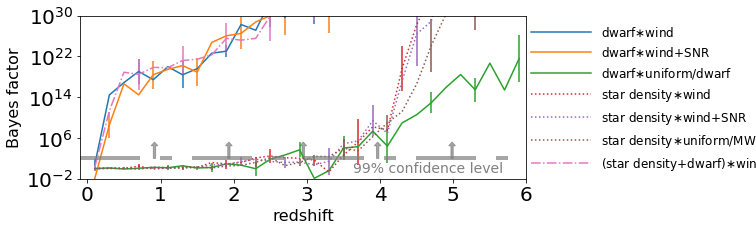

321 seconds


In [130]:
t0 = time()

zs = np.arange(0.1,6.0,0.2)
#zs = np.arange(0.1,0.6,0.1)
#zs = np.append( zs, np.arange( 0.7, 1.8, 0.2) )
#zs = np.append( zs, np.arange( 2.0, 5.1, 0.3) )
#zs = np.append( zs, np.arange( 5.5, 6.1, 0.5) )
model_IGM = list(models_all['model_IGM'])

fig, ax = plt.subplots( figsize=(8,3) )

ierror = 0
Nerror = 3

for mset, color, l in zip( models_noIGM_sets, colors_std, ['-', '-','-',':',':',':','-.'] ):
    models = []
    while len( models ) < len( model_IGM ):
        models.append( dict( mset ) )
    for im, m in enumerate( model_IGM ):
        models[im]['model_IGM'] = m
    B, B_std = [[],[]], [[],[]]
    
    for z in zs:
        for im, m in enumerate( models[:1] ):
            P_DM, x_DM = FullProbability( z=z, typ='DM', density=True, **m )
            P_RM, x_RM = FullProbability( z=z, typ='RM', density=True, **m )
            b, b_std, rm, rm_std = FakeTest( P_DM, x_DM, P_RM, x_RM, models[0], models[1], N=100, N_check=6 )
            B[im].append(b)
            B_std[im].append(b_std)
    for im, ( m, ll ) in enumerate( zip( model_IGM[:1], ['-', '--', '-.', ':' ] ) ):
        label=LabelCombinedModel( **mset ) if im==0 else None
        plt.plot( zs, B[im], label=label, linestyle=l, color=color )
        errorbar( zs[ierror:], B[im][ierror:], B_std[im][ierror:], color=color, errorevery=Nerror )    
    ierror += 1
    if ierror == Nerror:
        ierror = 0
    
        
#plt.loglog()
plt.yscale('log')
plt.ylabel('Bayes factor', fontdict={'size':16} )
plt.xlabel('redshift', fontdict={'size':16})
ylim = (1e-2,1e30)
xlim = (-0.1,6)
plt.ylim( *ylim )
plt.xlim( *xlim )
plot_limit( ax, [-0.1,6.0], [1e2,1e2], 'lower', xlim, ylim, value='99% confidence level',
           ylog=True, shift_text_horizontal=1.7, shift_text_vertical=-0.99e2,
           arrow_number=5 
          )

#plt.hlines( [1e2], -0.1, 6.0, color='gray', linewidth=2, linestyle='-.' )#, alpha=0.7 )
plt.legend(prop={'size':12}, handlelength=5, ncol=1, 
            bbox_to_anchor= (1., 0.01, 0.50, 1), loc='lower left',
            borderaxespad=0, frameon=False, markerfirst=True, mode='expand'
    )
ax.tick_params(labelsize=20)
plt.show()

print "%.0f seconds" % ( time() - t0 )

KeyError: 'Unable to open object (component not found)'

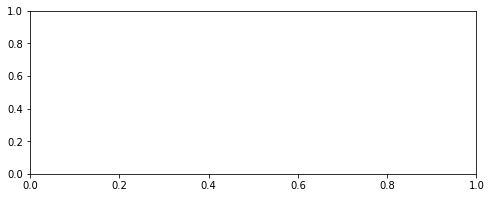

In [35]:
t0 = time()

zs = np.arange(0.1,6.0,0.2)
#zs = np.arange(0.1,0.6,0.1)
#zs = np.append( zs, np.arange( 0.7, 1.8, 0.2) )
#zs = np.append( zs, np.arange( 2.0, 5.1, 0.3) )
#zs = np.append( zs, np.arange( 5.5, 6.1, 0.5) )
model_IGM = list(models_all['model_IGM'])

fig, ax = plt.subplots( figsize=(8,3) )

ierror = 0
Nerror = 3

for mset, color, l in zip( models_noIGM_sets, colors_std, ['-', '-','-',':',':',':','-.'] ):
    models = []
    while len( models ) < len( model_IGM ):
        models.append( dict( mset ) )
    for im, m in enumerate( model_IGM ):
        models[im]['model_IGM'] = m
    B, B_std = [[],[]], [[],[]]
    
    for z in zs:
        for im, m in enumerate( models[:1] ):
#            P_DM, x_DM = FullProbability( z=z, typ='DM', density=True, **m )
#            P_RM, x_RM = FullProbability( z=z, typ='RM', density=True, **m )
            P_DM, x_DM = ObservableProbability( z=z, typ='DM', density=True, **m )
            P_RM, x_RM = ObservableProbability( z=z, typ='RM', density=True, **m )
            b, b_std, rm, rm_std = FakeTest( P_DM, x_DM, P_RM, x_RM, models[0], models[1], N=100, N_check=6 )
            B[im].append(b)
            B_std[im].append(b_std)
    for im, ( m, ll ) in enumerate( zip( model_IGM[:1], ['-', '--', '-.', ':' ] ) ):
        label=LabelCombinedModel( **mset ) if im==0 else None
        plt.plot( zs, B[im], label=label, linestyle=l, color=color )
        errorbar( zs[ierror:], B[im][ierror:], B_std[im][ierror:], color=color, errorevery=Nerror )    
    ierror += 1
    if ierror == Nerror:
        ierror = 0
    
        
#plt.loglog()
plt.yscale('log')
plt.ylabel('Bayes factor', fontdict={'size':16} )
plt.xlabel('redshift', fontdict={'size':16})
ylim = (1e-2,1e30)
xlim = (-0.1,6)
plt.ylim( *ylim )
plt.xlim( *xlim )
plot_limit( ax, [-0.1,6.0], [1e2,1e2], 'lower', xlim, ylim, value='99% confidence level',
           ylog=True, shift_text_horizontal=1.7, shift_text_vertical=-0.99e2,
           arrow_number=5 
          )

#plt.hlines( [1e2], -0.1, 6.0, color='gray', linewidth=2, linestyle='-.' )#, alpha=0.7 )
plt.legend(prop={'size':12}, handlelength=5, ncol=1, 
            bbox_to_anchor= (1., 0.01, 0.50, 1), loc='lower left',
            borderaxespad=0, frameon=False, markerfirst=True, mode='expand'
    )
ax.tick_params(labelsize=20)
plt.show()

print "%.0f seconds" % ( time() - t0 )

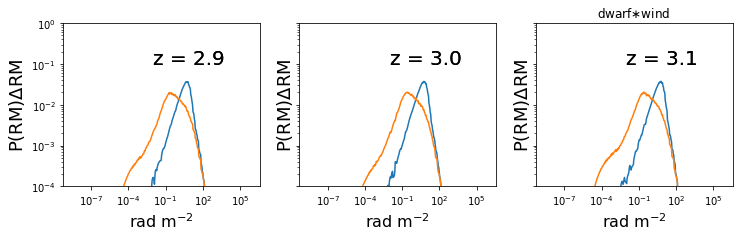

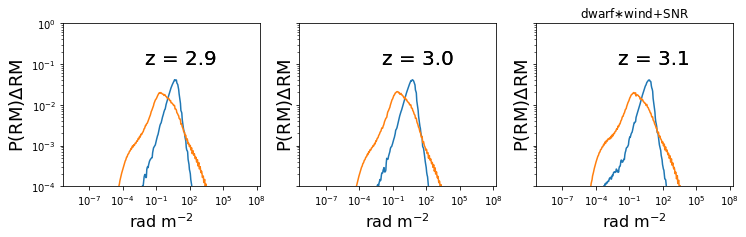

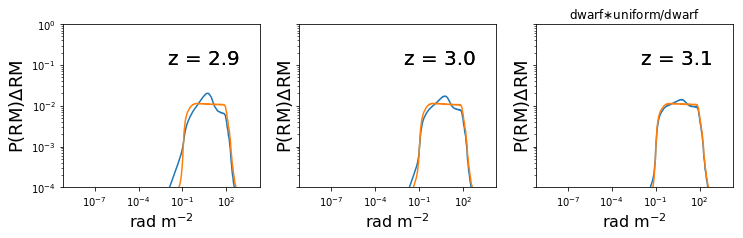

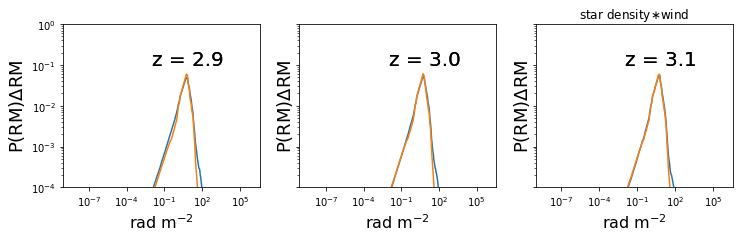

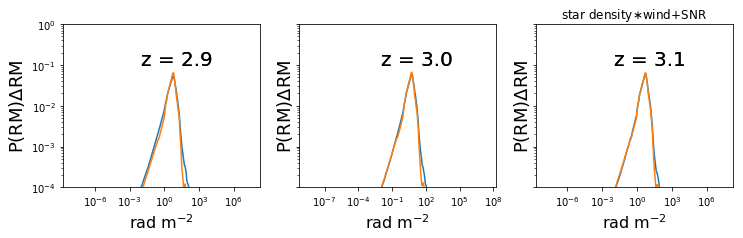

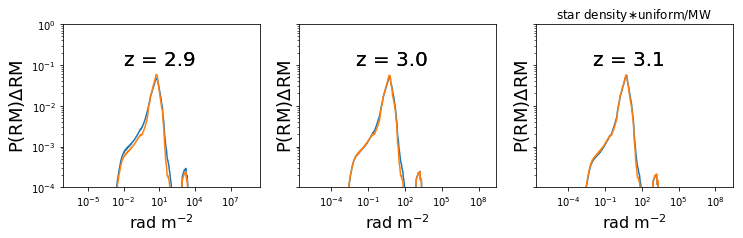

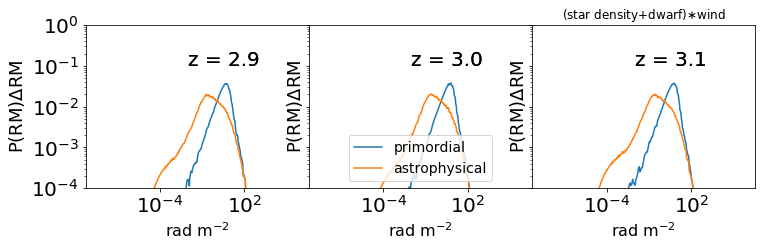

In [16]:
zs = [2.9, 3.0, 3.1]

for set in models_noIGM_sets:
    fig, axs = plt.subplots( 1, len(zs), figsize=(12,3), sharey='all' )
    plt.title( LabelCombinedModel( **set ) )
    for ax, z in zip( axs.flatten(), zs ):
        for i, model in enumerate( ['primordial','astrophysical'] ):
            P, x = FullProbability(z=z, typ='RM', model_IGM=[model], **set )
            PlotProbability( x, P, ax=ax, label=model, density=False, typ='RM' )
            ax.text( 1e-2, 1e-1, 'z = %.1f' % z, fontdict={'size':20})
        ax.set_ylim(1e-4, 1)
axs[1].legend(loc='lower center', prop={'size':14})
fig.subplots_adjust( hspace=0, wspace=0 )
for ax in axs:
    ax.tick_params(labelsize=20)
  

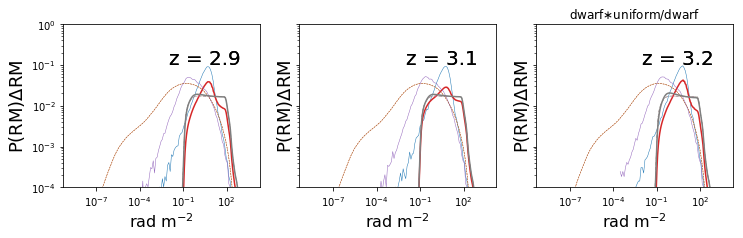

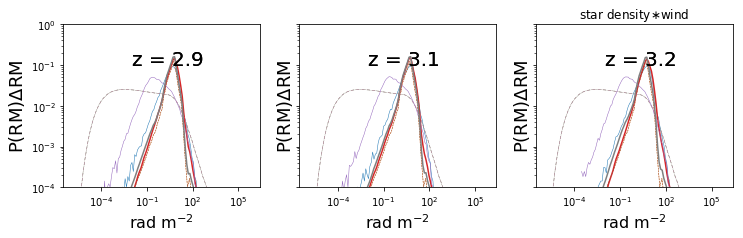

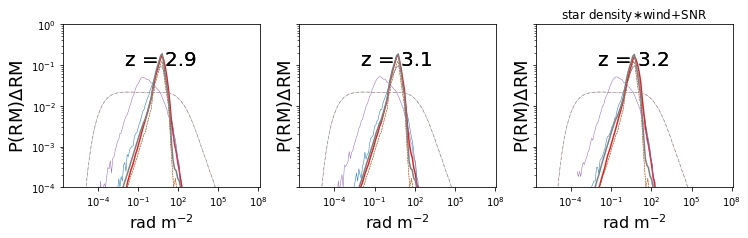

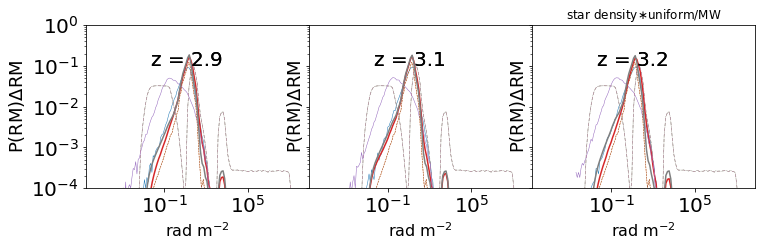

In [71]:
# !!! plot dwarf*uniform for increasing redshift

zs = [2.9, 3.1, 3.2]
#zss = np.arange(2.1,5.1,0.1).reshape(10,3)[3:4]
set = models_noIGM_sets[2]
for set in models_noIGM_sets[2:6]:
#for zs in zss:
    fig, axs = plt.subplots( 1, len(zs), figsize=(12,3), sharey='all' )
    plt.title( LabelCombinedModel( **set ) )
    for ax, z in zip( axs.flatten(), zs ):
        for i, model in enumerate( ['primordial','astrophysical'] ):
            P, x = FullProbability(z=z, typ='RM', model_IGM=[model], ax=ax, force=True, **set )
            PlotProbability( x, P, ax=ax, label=model, density=False, typ='RM' )
            ax.text( 1e-2, 1e-1, 'z = %.1f' % z, fontdict={'size':20})
        ax.set_ylim(1e-4, 1)
#axs[1].legend(loc='lower center', prop={'size':14})
fig.subplots_adjust( hspace=0, wspace=0 )
for ax in axs:
    ax.tick_params(labelsize=20)
  

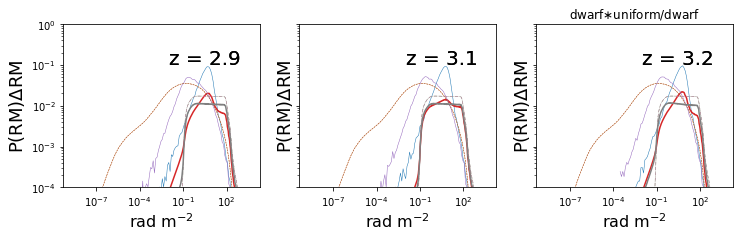

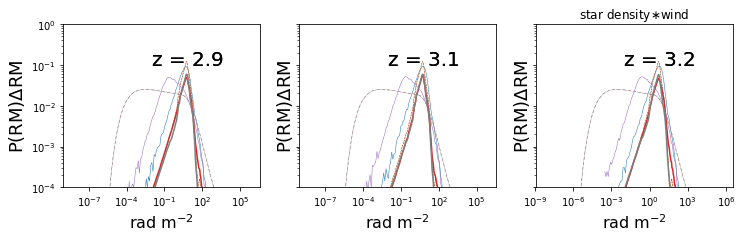

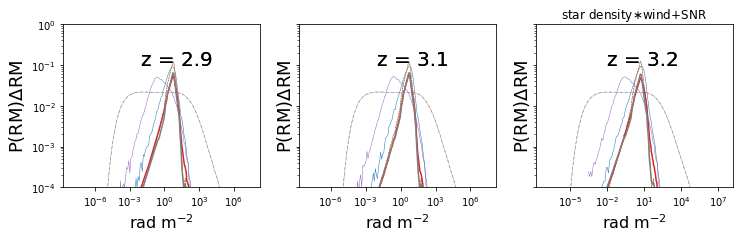

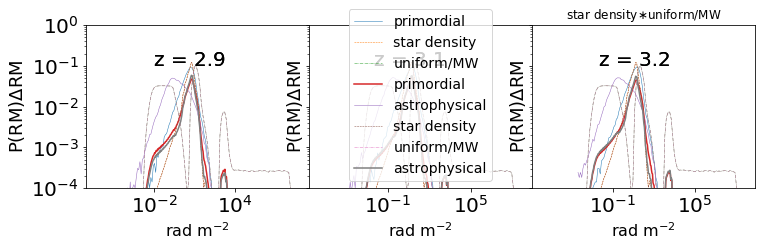

In [64]:
# !!! plot dwarf*uniform for increasing redshift

zs = [2.9, 3.1, 3.2]
#zss = np.arange(2.1,5.1,0.1).reshape(10,3)[3:4]
set = models_noIGM_sets[2]
for set in models_noIGM_sets[2:6]:
#for zs in zss:
    fig, axs = plt.subplots( 1, len(zs), figsize=(12,3), sharey='all' )
    plt.title( LabelCombinedModel( **set ) )
    for ax, z in zip( axs.flatten(), zs ):
        for i, model in enumerate( ['primordial','astrophysical'] ):
            P, x = FullProbability(z=z, typ='RM', model_IGM=[model], ax=ax, force=True, **set )
            PlotProbability( x, P, ax=ax, label=model, density=False, typ='RM' )
            ax.text( 1e-2, 1e-1, 'z = %.1f' % z, fontdict={'size':20})
        ax.set_ylim(1e-4, 1)
#axs[1].legend(loc='lower center', prop={'size':14})
fig.subplots_adjust( hspace=0, wspace=0 )
for ax in axs:
    ax.tick_params(labelsize=20)
  

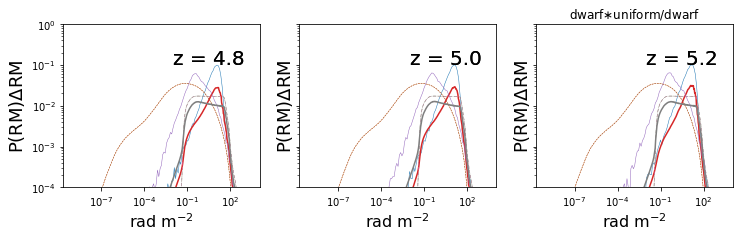

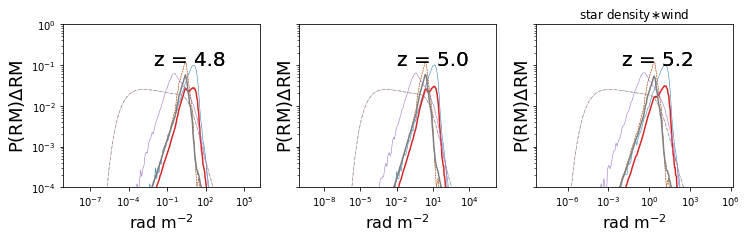

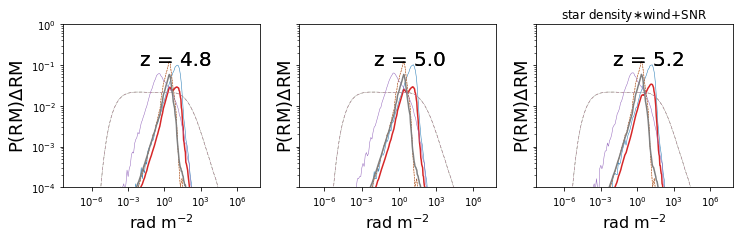

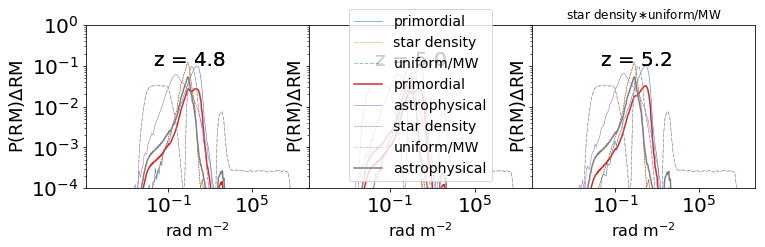

In [65]:
# !!! plot dwarf*uniform for increasing redshift

zs = [4.8, 5.0, 5.2]
#zss = np.arange(2.1,5.1,0.1).reshape(10,3)[3:4]
set = models_noIGM_sets[2]
for set in models_noIGM_sets[2:6]:
#for zs in zss:
    fig, axs = plt.subplots( 1, len(zs), figsize=(12,3), sharey='all' )
    plt.title( LabelCombinedModel( **set ) )
    for ax, z in zip( axs.flatten(), zs ):
        for i, model in enumerate( ['primordial','astrophysical'] ):
            P, x = FullProbability(z=z, typ='RM', model_IGM=[model], ax=ax, force=True, **set )
            PlotProbability( x, P, ax=ax, label=model, density=False, typ='RM' )
            ax.text( 1e-2, 1e-1, 'z = %.1f' % z, fontdict={'size':20})
        ax.set_ylim(1e-4, 1)
#axs[1].legend(loc='lower center', prop={'size':14})
fig.subplots_adjust( hspace=0, wspace=0 )
for ax in axs:
    ax.tick_params(labelsize=20)
  

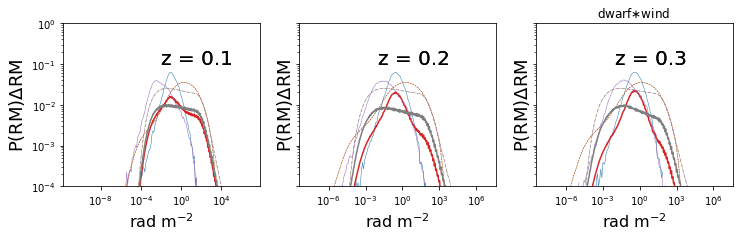

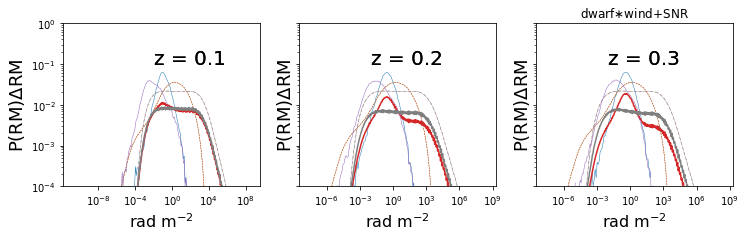

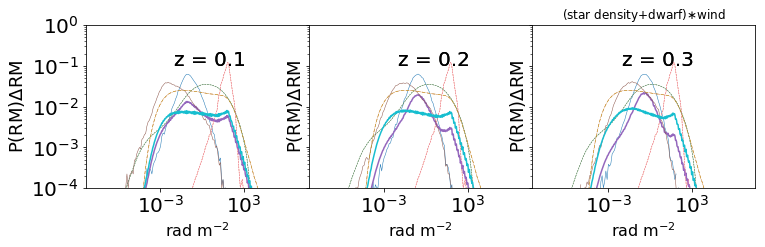

In [67]:
# !!! plot dwarf*uniform for increasing redshift

zs = [0.1,0.2,0.3]
#zss = np.arange(2.1,5.1,0.1).reshape(10,3)[3:4]
set = models_noIGM_sets[2]
for set in [ models_noIGM_sets[i] for i in [0,1,-1]]:
#for zs in zss:
    fig, axs = plt.subplots( 1, len(zs), figsize=(12,3), sharey='all' )
    plt.title( LabelCombinedModel( **set ) )
    for ax, z in zip( axs.flatten(), zs ):
        for i, model in enumerate( ['primordial','astrophysical'] ):
            P, x = FullProbability(z=z, typ='RM', model_IGM=[model], ax=ax, force=True, **set )
            PlotProbability( x, P, ax=ax, label=model, density=False, typ='RM' )
            ax.text( 1e-2, 1e-1, 'z = %.1f' % z, fontdict={'size':20})
        ax.set_ylim(1e-4, 1)
#axs[1].legend(loc='lower center', prop={'size':14})
fig.subplots_adjust( hspace=0, wspace=0 )
for ax in axs:
    ax.tick_params(labelsize=20)
  

low redshift combination spiral dwarf

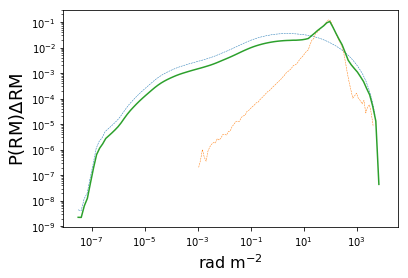

In [32]:
typ='RM'
fig, ax = plt.subplots()
P, x = ModelProbability( 'Host', ['Heesen11/dirty','JF12/StarDensity_MW'], weight='', weights=[1,1], typ=typ, ax=ax )
PlotProbability( x, P, density=False, label='full', ax=ax, typ=typ )

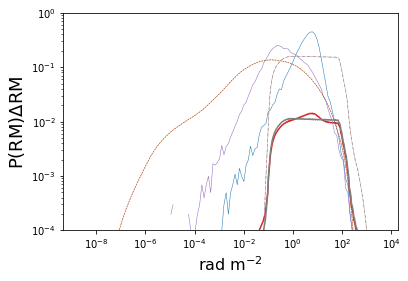

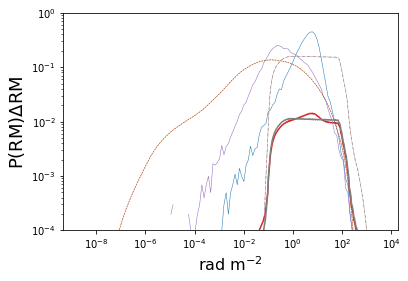

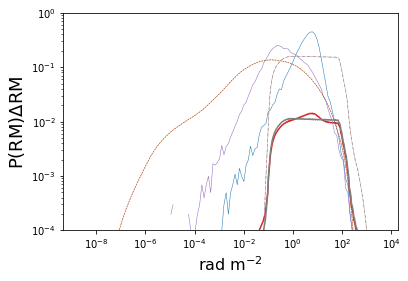

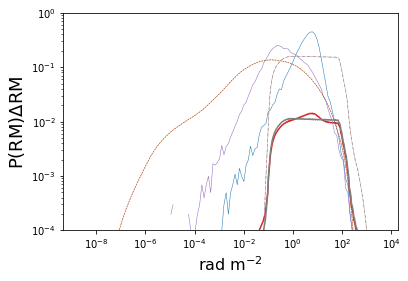

In [16]:
for z in [2.9,3.0,3.1,3.2]:
    fig, ax = plt.subplots()
    typ='RM'
    for m in models_all['model_IGM']:
        s = models_noIGM_sets[2]
        s['model_IGM'] = [m]
        P, x = FullProbability( z=3.1, ax=ax, typ=typ, force=True, **s )
        PlotProbability( x, P, ax=ax, typ=typ)
        plt.ylim(1e-4,1)
    plt.show()

In [16]:
s = dict( models_noIGM_sets[2] )
print s
s_all = dict(s)
#s['model_IGM'] = []
s['model_Progenitor'] = [ 'Piro18/uniform/Heesen11' ]
s['model_Host'] = []
s_Prog = dict(s)
s['model_Host'] = ['Heesen11/dirty']
s['model_Progenitor'] = [] 
s_Host = dict(s)




{'model_Host': ['Heesen11/dirty'], 'weight_Host': '', 'model_MW': [], 'model_Progenitor': ['Piro18/uniform/Heesen11']}


In [18]:
def PlotProbFast( s, z, typ='RM', ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    P, x = FullProbability( z=z, ax=ax, typ=typ, model_IGM=['primordial'], force=True, **s )
    PlotProbability( x, P, ax=ax, typ=typ, color='blue', **kwargs)
    P, x = FullProbability( z=z, ax=ax, typ=typ, model_IGM=['astrophysical'], force=True, **s )
    PlotProbability( x, P, ax=ax, typ=typ, color='orange', **kwargs)
#    ax.set_xlim(1e-4,1e3)
    ax.set_title( 'z=%.1f' % z)
    ax.set_ylim(1e-4,1)


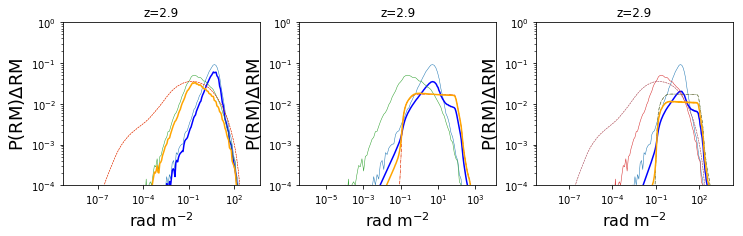

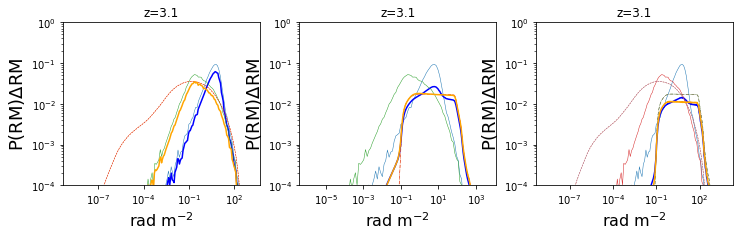

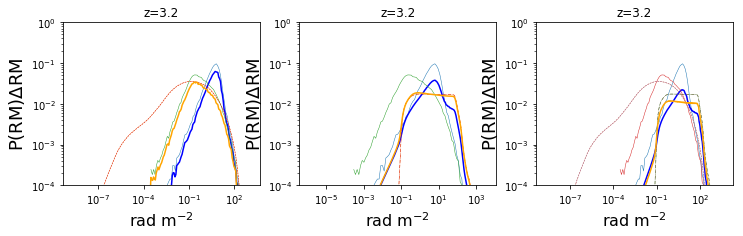

In [117]:
for z in [2.9, 3.1,3.2]:
    fig, axs = plt.subplots(1,3, figsize=(12,3) )

    PlotProbFast( s_Host, z=z, ax=axs[0] )
    PlotProbFast( s_Prog, z=z, ax=axs[1] )
    PlotProbFast( s_all, z=z, ax=axs[2] )
    plt.show()


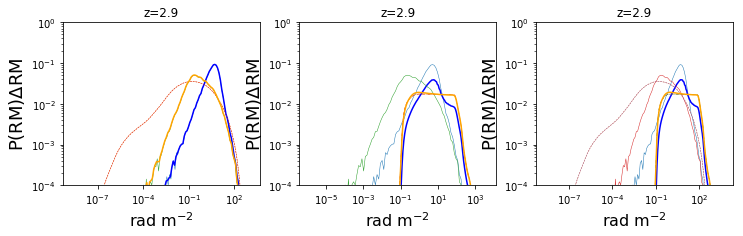

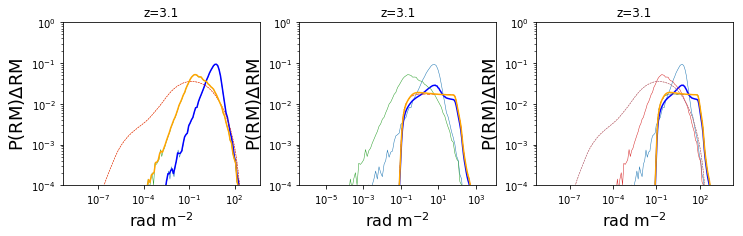

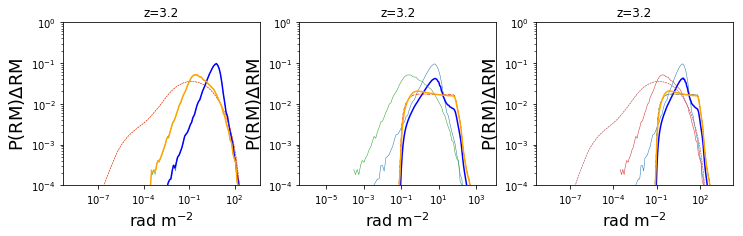

In [120]:
for z in [2.9, 3.1,3.2]:
    fig, axs = plt.subplots(1,3, figsize=(12,3) )

    PlotProbFast( s_Host, z=z, ax=axs[0] )
    PlotProbFast( s_Prog, z=z, ax=axs[1] )
    PlotProbFast( s_all, z=z, ax=axs[2] )
    plt.show()


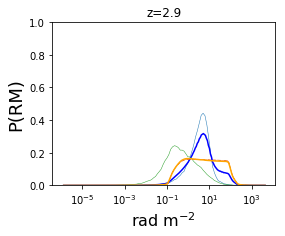

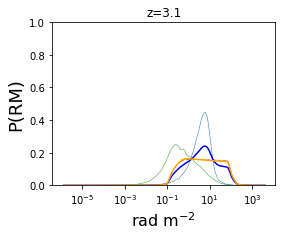

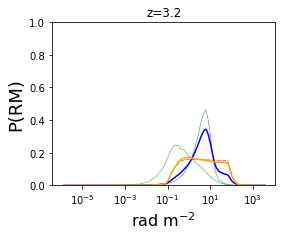

In [36]:
#fig, axs = plt.subplots(1,3, figsize=(12,3) )
fig, ax = plt.subplots( figsize=(4,3) )
axs = [ax]
PlotProbFast( s_Prog, z=2.9, ax=axs[0], cumulative=False, density=True )
plt.yscale('linear')
fig, ax = plt.subplots( figsize=(4,3) )
axs = [ax]
PlotProbFast( s_Prog, z=3.1, ax=axs[0], cumulative=False, density=True )
plt.yscale('linear')
fig, ax = plt.subplots( figsize=(4,3) )
axs = [ax]
PlotProbFast( s_Prog, z=3.2, ax=axs[0], cumulative=False, density=True )
plt.yscale('linear')
plt.show()


In [19]:
N=30
def TestConvolution( shift=0, N=30, ax=None, cumulative=False ):
    f = np.ones(N)
    x_f = 10.**np.linspace(1,3,N+1)
    dx_f = np.diff( x_f )
    x_f_ = x_f[:-1] + dx_f/2

    f /= dx_f
    f /= np.sum( f*dx_f )

    x_g = 10.**np.linspace(1+shift,3+shift,N+1)
    dx_g = np.diff( x_g )
    x_g_ = x_g[:-1] + dx_g/2
    g = np.sin(x_g_/x_g[-1]*np.pi)

    g /= dx_g
    g /= np.sum( g*dx_g )

    if ax is None:
        fig, ax = plt.subplots()
    PlotProbability(x_f, f, ax=ax, density=False, cumulative=cumulative )
    PlotProbability(x_g, g, ax=ax, density=False, cumulative=cumulative )
    
    P, x = ConvolveProbabilities( [f,g], [x_f,x_g], absolute=True )
    PlotProbability(x, P, ax=ax, density=False, cumulative=cumulative )
    print np.sum( f*np.diff(x_f) )
    print np.sum( g*np.diff(x_g) )
    print np.sum( P*np.diff(x) )





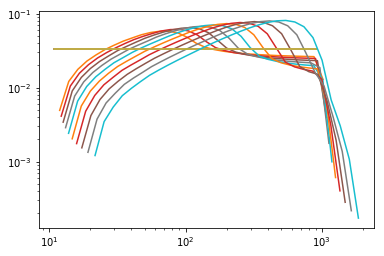

In [153]:
#fig, axs = plt.subplots( 10,1,figsize=(4,30) )
fig, ax = plt.subplots( ) #10,1,figsize=(4,30) )
shifts = np.linspace(-1,0,10)
#for sh, ax in zip( shifts, axs):
for sh in shifts:
    TestConvolution( shift=sh, ax=ax )

1.0
1.0
1.0


(0.0001, 1)

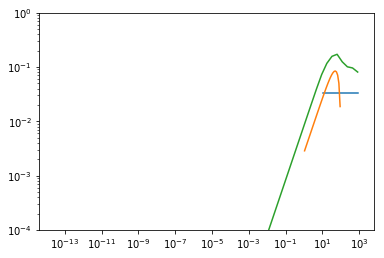

In [24]:
fig, ax = plt.subplots()
TestConvolution(shift=-1, cumulative=False, ax=ax)
plt.ylim(1e-4,1)

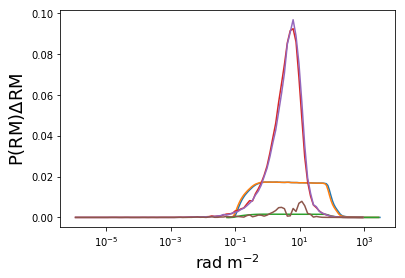

In [39]:
fig, ax = plt.subplots( ) #10,1,figsize=(4,30) )


P3, x3 = FullProbability( z=3.1, typ='RM', **s_Prog )
PlotProbability( x3, P3, typ=typ, ax=ax )
P2, x2 = FullProbability( z=3.3, typ='RM', **s_Prog )
PlotProbability( x2, P2, typ=typ, ax=ax )
PlotProbability( x2, np.abs(P3-P2), typ=typ, ax=ax )
plt.yscale('linear')

P3, x3 = FullProbability( z=3.1, typ='RM', model_IGM=['primordial'] )
PlotProbability( x3, P3, typ=typ, ax=ax )
P2, x2 = FullProbability( z=3.3, typ='RM', model_IGM=['primordial'])
PlotProbability( x2, P2, typ=typ, ax=ax )
PlotProbability( x2, np.abs(P3-P2), typ=typ, ax=ax )
plt.yscale('linear')

plt.show()


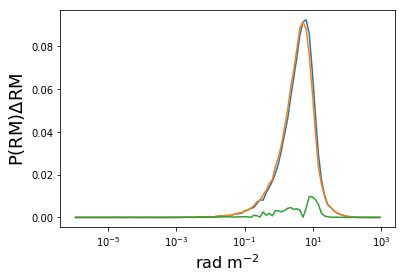

In [37]:
fig, ax = plt.subplots( ) #10,1,figsize=(4,30) )



plt.show()
